# House Prices: Advanced Regression techniques
This notebook is my attempt in the [House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)  data science competition hosted by Kaggle.

In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## First exploration steps
### removing columns with a high Nan ratio

In [2]:
train_file = "train.csv"
test_file = "test.csv"

In [3]:
df_train_org = pd.read_csv(train_file)
df_test_org = pd.read_csv(test_file)

In [4]:
# understand the data
# print(df_train_org.head()) 
# so we can see that there  are 79 features 
print(len(df_train_org))
# and 1460 training samples

1460


In [5]:
df = df_train_org.copy()

In [6]:
y = df.loc[:, "SalePrice"]
df = df.rename(columns={"SalePrice":"y"})
# df = df.drop("y", axis=1)

In [7]:
l = df.isna().sum().tolist()
null_lists = [i for i in range(len(l)) if l[i] > 0]
print(df.columns[null_lists])

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [8]:
# let's consider the ratio of non-Na values
l_ratio = np.array(l) / len(df)

nan_threshold = 0.8 # any feature with a non ration higher than 0.8 will be droppped
drop = l_ratio >= nan_threshold
valid_cols = [i for i in range(len(drop)) if not drop[i]]

invalid_cols = [i for i in range(len(drop)) if drop[i]]
print(df.columns[invalid_cols])


Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [9]:
df_test = df_test_org.copy()

In [10]:

df = df.iloc[:, valid_cols].drop("Id", axis=1)
df_test = df_test.iloc[:, valid_cols[:-1]].drop("Id", axis=1)
combined = [df, df_test]


In [11]:
df2 = df.copy() 
y = "y"

### Data exploration


In [12]:
agg_func = ['count', np.mean, np.max, np.min]


In [13]:
summary = df.describe()

In [14]:
NUM_COLS = summary.columns.tolist()
print(len(NUM_COLS))
CAT_COLS = [col for col in df.columns.tolist() if col not in NUM_COLS]
print(len(CAT_COLS))

37
39


In [15]:
def plot_num_feature_price(start, number):
    global df, agg_func
    
    for j in range(start, min(start+number, len(NUM_COLS) - 1)):
        if NUM_COLS[j] in df.columns:
            try:
                df.plot(kind='scatter', x=NUM_COLS[j], y='y', title="{}'s effect on price".format(NUM_COLS[j]))
            except:
                print(pd.pivot_table(df, index=NUM_COLS[j], values=y, aggfunc=agg_func))
        else:
            print(NUM_COLS[j] + " has already been dropped in the previous sections")


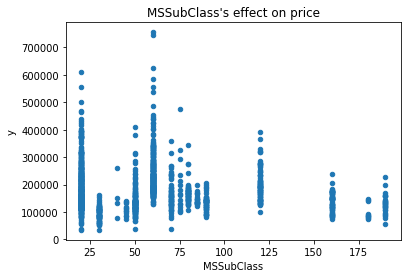

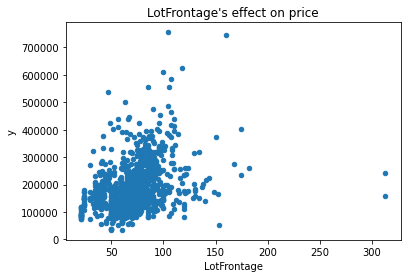

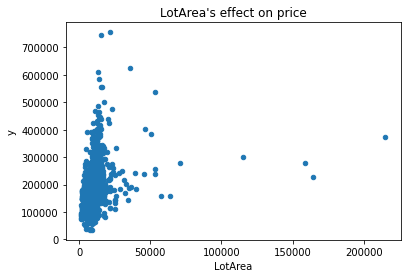

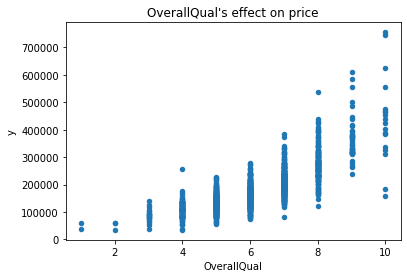

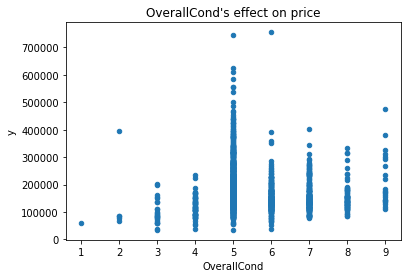

In [16]:
plot_num_feature_price(0, 5)


Insights after considering these plots:
* certain zones set a limit to the lot's price, others don't: consider pivoting the table on zones
* lot's frontage and lot's aread  might not be good indicators
* it might be a good idea to combine quality and condition to find a better feature

##### Working on the house's class:

In [17]:
# even though this feature is numerical, it semantically categorical. 
# My suggestion is to limit its possible categories by the price of its most expensive house
ms_class = "MSSubClass"
for d in combined:
    d.rename(columns={ms_class:"sub_c"}, inplace=True)


In [18]:
sub_c  = "sub_c"
price_per_class = pd.pivot_table(df, index=sub_c, values='y', aggfunc=['count', np.median, np.mean, np.min, np.max])

print(price_per_class.sort_values(("median", "y"), ascending=False))

      count  median           mean    amin    amax
          y       y              y       y       y
sub_c                                             
60      299  215200  239948.501672  129000  755000
120      87  192000  200779.080460   99500  392500
80       58  166500  169736.551724  107000  345000
75       16  163500  192437.500000  101000  475000
20      536  159250  185224.811567   35311  611657
70       60  156000  166772.416667   40000  359100
160      63  146000  138647.380952   75000  239000
40        4  142500  156125.000000   79500  260000
85       20  140750  147810.000000  123000  198500
90       52  135980  133541.076923   82000  206300
50      144  132000  143302.972222   37900  410000
190      30  128250  129613.333333   55000  228950
45       12  107500  108591.666667   76000  139400
30       69   99900   95829.724638   34900  163500
180      10   88500  102300.000000   75500  148000


In [19]:
for d in combined:
    d['sub_c']= d['sub_c'].apply(lambda x: x if x != 150 else 120)

for d in combined:
   d["sub_c"] = d["sub_c"].apply(lambda x: price_per_class.loc[x, ("amax", "y")].squeeze() // (10 ** 5))

##### working on quality + condition
let's consider combining both these features into one.

In [20]:
df, df_test = combined
qua = "OverallQual"
con = "OverallCond"

price_by_con = pd.pivot_table(df, index=con, values='y', aggfunc=['count', np.nanmean, np.min, np.max])
print(price_by_con)


            count        nanmean    amin    amax
                y              y       y       y
OverallCond                                     
1               1   61000.000000   61000   61000
2               5  141986.400000   67000  394432
3              25  101929.400000   35311  200624
4              57  120438.438596   40000  235000
5             821  203146.914738   34900  745000
6             252  153961.591270   37900  755000
7             205  158145.487805   79900  402000
8              72  155651.736111   84500  335000
9              22  216004.545455  110500  475000


In [21]:
pri_qua_con = df.loc[:, [con, qua, y]]
qua_price = {} #to store all the pair of houses where one house's quality is better than the other while the price is not in the same direction
l = len(pri_qua_con)
for i in range(l):
    for j in range(i + 1, l):
        if pri_qua_con.iloc[i, 1].squeeze() > pri_qua_con.iloc[j, 1].squeeze() \
        and pri_qua_con.iloc[i, 2].squeeze() < pri_qua_con.iloc[j, 2].squeeze() \
        and pri_qua_con.iloc[i, 0].squeeze() != pri_qua_con.iloc[j, 0].squeeze(): 
            qua_price[(i, j)] = [pri_qua_con.iloc[i, :], pri_qua_con.iloc[j, :]]


In [22]:
# the two feature condition and quality will be transformed into a single feature: evalution = con * coeff + qua
# it is time to calculate coeff
coeff = 0

for value in qua_price.values():
    coeff += abs(value[0][con] - value[1][con]) / abs(value[0][qua] - value[1][qua])  - 1
coeff /= len(qua_price)
print(coeff)


0.6578436218512


In [23]:
for i in range(2):
    combined[i]['eval'] = (combined[i][qua] + coeff * combined[i][con]).astype(int)

for i in range(2):
    try:
        combined[i].drop([con, qua], axis=1, inplace=True)
    except:
        print("already dropped")

df, df_test = combined

In [24]:
# also drop the lot's aread column: it is replaced with more significant areas
for i in range(2):
    try:
        combined[i].drop("LotArea", axis=1, inplace=True)
    except:
        print("already dropped")
NUM_COLS.remove("LotArea")
df, df_test = combined

MSSubClass has already been dropped in the previous sections
OverallQual has already been dropped in the previous sections
OverallCond has already been dropped in the previous sections


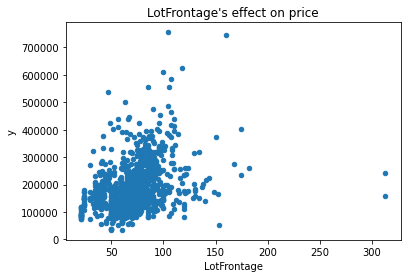

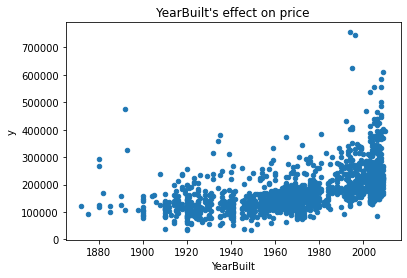

In [25]:
plot_num_feature_price(0, 5)


Insights on the considered features:
* the MSVerArea should not be used as it is
* as for the first Basement, the larger the better
* the surface of the 2nd basement does not seem to affect the price much
* It might be worth considering only YearRemoddAdd

#### Working the Basement's features

In [26]:
# dropping the unfinished area
for i in range(2):
    try:
        combined[i].drop('BsmtUnfSF', axis=1, inplace=True)
    except:
        print("already dropped")
# NUM_COLS.remove('BsmtUnfSF')
df, df_test = combined


In [27]:
# hypothese, with a second basement present, the first basement is not that large
sec_bas_area = "BsmtFinSF2"
# print(np.unique(df[sec_bas_area].values))
fir_bas_area = "BsmtFinSF1"
only_one_basement = df[(df[sec_bas_area] == 0) & (df[fir_bas_area] > 0)] 
with_sec_bas = df[(df[sec_bas_area] > 0) & (df[fir_bas_area] > 0)]
print(only_one_basement[fir_bas_area].describe())
print("#" * 70)
print(with_sec_bas[fir_bas_area].describe())

count     826.000000
mean      694.041162
std       417.640577
min         2.000000
25%       419.250000
50%       648.000000
75%       928.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64
######################################################################
count     167.000000
mean      445.724551
std       309.535460
min        25.000000
25%       230.000000
50%       375.000000
75%       579.500000
max      1767.000000
Name: BsmtFinSF1, dtype: float64


In [28]:
## let's consider more the basement related features as more correlations probably exist
bas_h = "BsmtQual"		
bas_c = "BsmtCond" 
bas_x = "BsmtExposure"
bas_r1 = "BsmtFinType1"
bas_r2 = "BsmtFinType2"

bas_h_v = ["Ex","Gd","TA","Fa","Po","NA"]
bas_c_v= bas_h_v
bas_x_v = ["Gd", "Av", "Mn", "No", "NA"]
bas_r1_v = ["GLQ","ALQ","BLQ"	,"Rec"	,"LwQ"	,"Unf",	"NA"]
bas_r2_v = bas_r1_v
# let's first set them to ordincal categorical columns
feats = [bas_h, bas_c, bas_x, bas_r1, bas_r2]
order = [bas_h_v, bas_c_v, bas_x_v, bas_r1_v, bas_r2_v]

for f, o in zip(feats, order):
    d[f] = df[f].astype("category").cat.set_categories(o[::-1], ordered=True)

for f, o in zip(feats, order):
    df_test[f] = df_test[f].astype("category").cat.set_categories(o[::-1], ordered=True)

## this part was added later after experiementing


In [29]:
bas_feats = [fir_bas_area, sec_bas_area]
bas_feats.extend(feats)
# print(df[feats].isna().sum())
# let's work on imputing the missing values.
df_bas_mis = df[(df[bas_h].isna()) | (df[bas_c].isna()) | (df[bas_x].isna()) | (df[bas_r1].isna()) | (df[bas_r2].isna())] 

print(df_bas_mis.loc[:, bas_feats])

      BsmtFinSF1  BsmtFinSF2 BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
17             0           0      NaN      NaN          NaN          NaN   
39             0           0      NaN      NaN          NaN          NaN   
90             0           0      NaN      NaN          NaN          NaN   
102            0           0      NaN      NaN          NaN          NaN   
156            0           0      NaN      NaN          NaN          NaN   
182            0           0      NaN      NaN          NaN          NaN   
259            0           0      NaN      NaN          NaN          NaN   
332         1124         479       Gd       TA           No          GLQ   
342            0           0      NaN      NaN          NaN          NaN   
362            0           0      NaN      NaN          NaN          NaN   
371            0           0      NaN      NaN          NaN          NaN   
392            0           0      NaN      NaN          NaN          NaN   
520         

In [30]:
# convert the ordinal data to numerical:
def ord_to_num(unique_values, in_order=True):
    uni_v = unique_values if in_order else unique_values[::-1]
    return dict(zip(uni_v, range(0, len(unique_values))))

for f, o in zip(feats, order):
    df[f] = df[f].apply(ord_to_num(o, in_order=False).get)

for f, o in zip(feats, order):
    df_test[f] = df_test[f].apply(ord_to_num(o, in_order=False).get)


In [31]:
# as we can see from the output, rows associated with Nan vaulues in the basement criteria columns 0.0 in the basement area
# with the exception of a single row

df[feats] = df[feats].fillna(0)
df_test = df_test.fillna(0)

In [32]:
print(df[feats].isna().sum())

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64


The final evaluation of a basement's quality is as follows:
$\begin{align}
E =  \frac{c_1 \cdot \frac{BasQua}{6} + c_2 \cdot \frac{BasCon}{6} + c_3 \cdot \frac{BasExp}{5} + c_4 \cdot \frac{BasType1}{7}}{4}
\end{align}$
where $c_i$ represents is the correlation of the $i$-th criteria with ***y*** divided by the sum of correlations.

In [33]:
# let' calculate correlations    

corr = np.array([df.loc[:, [f, y]].corr()[y][f] for f in feats])
corr = [c / np.sum(corr) for c in corr]
c1, c2, c3, c4, c5 = corr
print(corr)

[0.3975335044701723, 0.14442486031043222, 0.2545325861623594, 0.20712509260601586, -0.003616043548979723]


In [34]:
def bas_eval(row):
    row['bas_eval_1'] = c1 * row[bas_h] / 6 + c2 * row[bas_c] / 6 + c3 * row[bas_x] / 5 + c4 * row[bas_r1] / 7
    row['bas_eval_1'] = row['bas_eval_1'] / 4
    return row

df = df.apply(bas_eval, axis=1)
df['bas_eval_2'] = c5 * df[bas_r2] / 7

df_test = df_test.apply(bas_eval, axis=1)
df_test['bas_eval_2'] = c5 * df_test[bas_r2] / 7



The final numerical value that best describes the basement contribution to the sale price is engineered as follows:
$\begin{align} E_1 \cdot area_1 + E_2 \cdot area_2
\end{align}$

In [35]:
# after adding the final evaluation
def basement(row):
    row['bas'] = row['bas_eval_1'] * row[fir_bas_area] + row['bas_eval_2'] * row[sec_bas_area]
    return row

df = df.apply(basement, axis=1)
df_test = df_test.apply(basement, axis=1)



In [36]:
print(df.loc[:, [y,'bas']].corr()[y]['bas']) 
for f in bas_feats:
    print(df.loc[:, [y, f]].corr()['y'][f])

0.4610529271803999
0.38641980624215344
-0.011378121450215155
0.5852071991725194
0.21260715648557857
0.37469622100088584
0.30490787307063305
-0.005323160673474905


With a large number of basement-related features, the new feature **bas** incorporates as much information as possible. With a relatively high correlation of 0.45 it might represent a good indicator of the house' price.
These changes will be applied to both train and test sets

In [37]:
bas_feats.extend(['bas_eval_1', 'bas_eval_2', "TotalBsmtSF"])

df.drop(bas_feats, inplace=True, axis=1)
df_test.drop(bas_feats, inplace=True, axis=1)

#### studying the effect of the floors' areas and living area


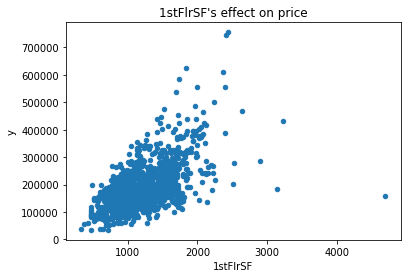

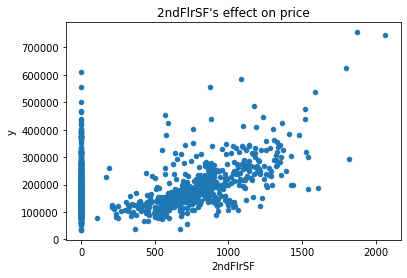

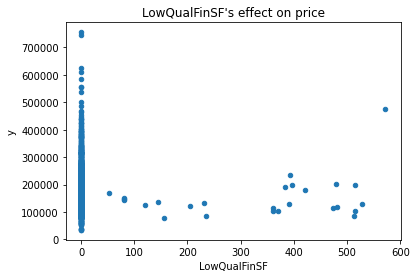

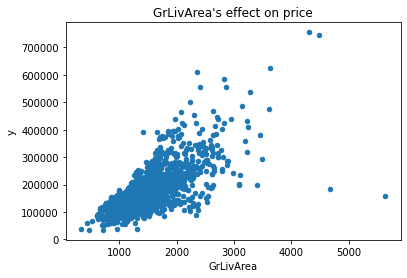

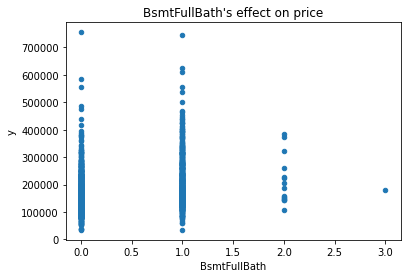

In [38]:
plot_num_feature_price(11, 5)


insights:
* The total unfinished area might be dropped
* The total basement's surface seems to positively correlate with the price
* The floors' areas correlates positively
* lowQualityFin surface will most probably be dropped

In [39]:
# the basement's surface will be dropped in favor of the "bas" feature engineered in the previous section.

# the lowQualityFin is to be dropped

df.drop("LowQualFinSF", axis=1, inplace=True)
df_test.drop("LowQualFinSF", axis=1, inplace=True)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='y'>

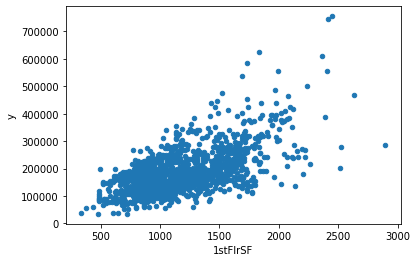

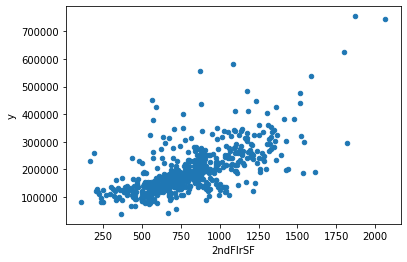

In [40]:
f1_a = "1stFlrSF"
f2_a = "2ndFlrSF"

df_most_a = df[df[f1_a] <= 3000]

df_most_a.plot(kind='scatter', x=f1_a, y=y,)

df_f2 = df[df[f2_a] > 0]
df_f2.plot(kind='scatter', x=f2_a, y=y)

In [41]:
print(df.loc[:, [f1_a, f2_a, y]].corr()['y'])
floors = df.loc[:, [f1_a, f2_a, y]]
print(floors[floors[f1_a] <= floors[f2_a]])

1stFlrSF    0.605852
2ndFlrSF    0.319334
y           1.000000
Name: y, dtype: float64
      1stFlrSF  2ndFlrSF       y
20        1158      1218  325300
30         649       668   40000
35        1132      1320  309000
57         860       860  196500
58        1426      1519  438780
...        ...       ...     ...
1386      1392      1392  250000
1395      1133      1349  281213
1420       708       708  179900
1430       734      1104  192140
1450       896       896  136000

[190 rows x 3 columns]


          area         y
area  1.000000  0.716883
y     0.716883  1.000000


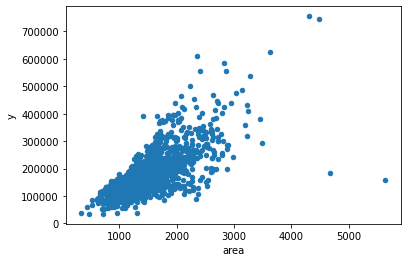

In [42]:
df['area'] = df[f1_a] + df[f2_a]
df.plot(kind='scatter', x='area', y=y)
df_test['area'] = df_test[f1_a] + df_test[f2_a]

print(df.loc[:, ['area', y]].corr())
# the total area is singificantly more correlated with the price than each of floor's areas individually

<AxesSubplot:xlabel='living_a_p', ylabel='y'>

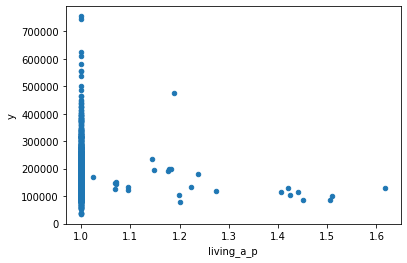

In [43]:
# let's consider another feature, which the percentage of the living area out of the total area
liv_a = "GrLivArea"
df['living_a_p'] = df[liv_a] / df['area']
df.plot(kind='scatter', x='living_a_p', y=y)

In [44]:
liv_area_more_total = df[df['living_a_p'] != 1]
liv_area_e_total = df[df['living_a_p'] == 1]
print(liv_area_more_total[y].describe())
print("#" * 70)
print(liv_area_e_total[y].describe())
# we can see that having living_a_p larger than one does significantly affect the price, thus it is most probably more beneficial
# to drop both living area and the new feature

df.drop([liv_a, 'living_a_p', f1_a, f2_a], axis=1, inplace=True)
df_test.drop([liv_a, f1_a, f2_a], axis=1, inplace=True)


count        26.000000
mean     152652.000000
std       77269.103373
min       79500.000000
25%      114625.000000
50%      131500.000000
75%      176875.000000
max      475000.000000
Name: y, dtype: float64
######################################################################
count      1434.000000
mean     181433.747559
std       79414.702594
min       34900.000000
25%      130000.000000
50%      163945.000000
75%      214800.000000
max      755000.000000
Name: y, dtype: float64


#### bathrooms and half bathrooms

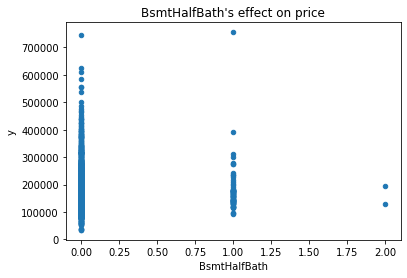

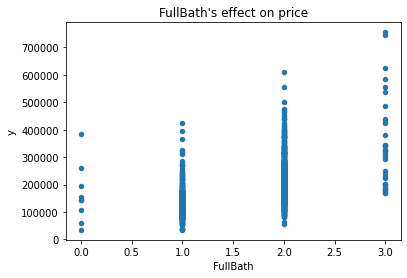

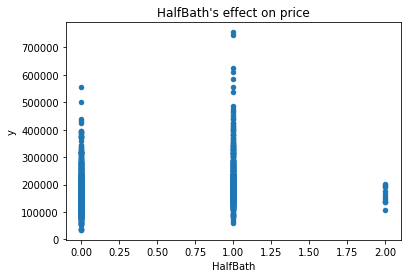

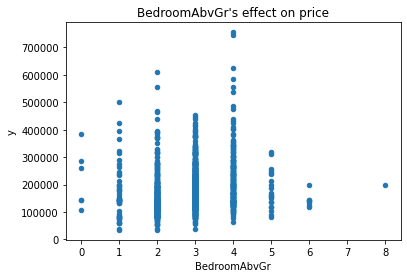

In [45]:
plot_num_feature_price(16, 4)


insights:
* all bath features should be combined into one final more expressive feature
* the living area is quite important feature

In [46]:
### adding all bathes together
b1 = "BsmtFullBath"
bh1 = "BsmtHalfBath"
b2 = "FullBath"
bh2 = "HalfBath"
df['baths'] = df[b1] + df[bh1] + df[b2] + df[bh2]
df_test['baths'] = df_test[b1] + df_test[bh1] + df_test[b2] + df_test[bh2]

df.drop([b1, bh1, b2, bh2], axis=1, inplace=True)
df_test.drop([b1, bh1, b2, bh2], axis=1, inplace=True)

#### working on rooms and kitchen

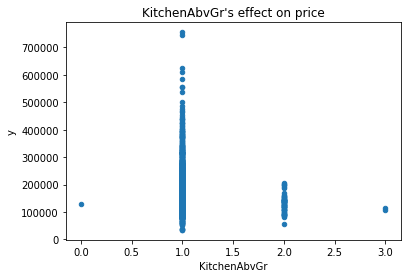

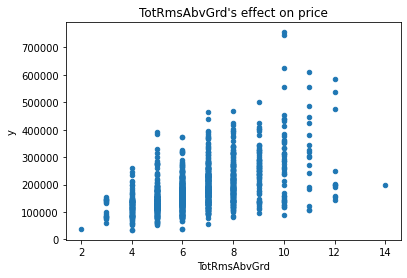

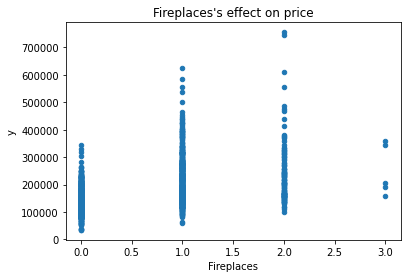

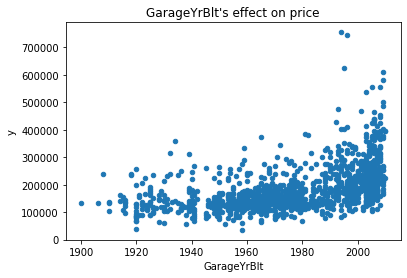

In [47]:
plot_num_feature_price(20, 4)


insights:
* the number of rooms should be coupled with the house's area. As a large number of houses might mean smaller ones which might lower the sale price.
* the number of kitchens is not too significant. a final feature including rooms, bathrooms and kitchen might be necessary


           area_room         y
area_room   1.000000  0.546174
y           0.546174  1.000000


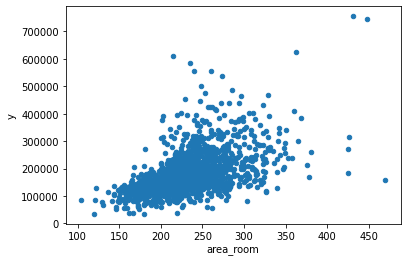

In [48]:
n_rooms = "TotRmsAbvGrd"
n_bed = "BedroomAbvGr"
df['area_room'] = df['area'] / df[n_rooms]
df.plot(kind='scatter', x='area_room', y=y)
print(df.loc[:, ['area_room', y]].corr())
# add the new feature to test set
df_test['area_room'] = df_test[n_rooms] / df_test['area']

df.drop([n_bed, n_rooms],axis=1, inplace=True)
df_test.drop([n_bed, n_rooms],axis=1, inplace=True)


In [49]:
kit = "KitchenAbvGr"

df[kit] = df_train_org[kit].copy()

In [50]:
# is kitchen significant?: the number is definitely not, let's check the quality
kit_q = "KitchenQual"
price_by_kit = pd.pivot_table(df, index=kit_q, values=y, aggfunc=['count', np.mean, np.max, np.min])
print(price_by_kit)

# we can see that kitchen's quality impacts the price range. houses with excellent houses are estimated by at least 86k. Additionally, the most expensive house is alos equipped with an excellent kitchen.

            count           mean    amax   amin
                y              y       y      y
KitchenQual                                    
Ex            100  328554.670000  755000  86000
Fa             39  105565.205128  200000  39300
Gd            586  212116.023891  625000  79000
TA            735  139962.511565  375000  34900


In [51]:
def set_kitchen(row):
    kit_qua = row[kit_q]
    if kit_qua not in price_by_kit.index:
        kit_qua = "TA"
    min = price_by_kit.loc[kit_qua, ('amin', 'y')].squeeze()
    max = price_by_kit.loc[kit_qua, ('amax', 'y')].squeeze()
    count = price_by_kit.loc[kit_qua, ('count', 'y')].squeeze()
    row['kit'] = min + (max - min) / count
    return row
df = df.apply(set_kitchen, axis=1)
df_test = df_test.apply(set_kitchen, axis=1)
print(df.loc[:, ['kit', y]].corr())

          kit         y
kit  1.000000  0.608405
y    0.608405  1.000000


In [52]:
df_test.apply(set_kitchen, axis=1)
df.drop([kit_q, kit], axis=1, inplace=True)
df_test.drop([kit_q, kit], axis=1, inplace=True)

#### working on Garage

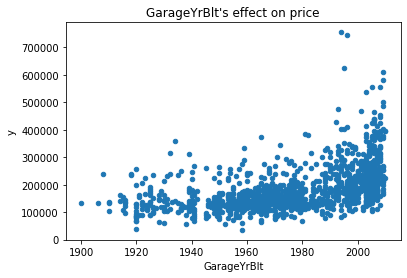

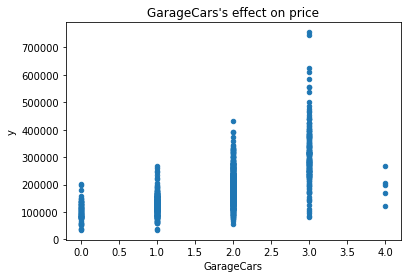

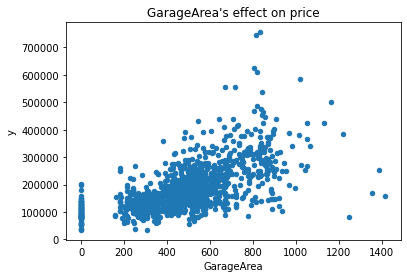

In [53]:
plot_num_feature_price(23, 3)

In [54]:
# similarly to the basement, garage is described by a number of other features such as condition, quality.
# let's consider all of them in this section
gt = "GarageType"
gf = "GarageFinish"
gq = "GarageQual"
gcon = "GarageCond"

gc = "GarageCars"
ga = "GarageArea"

gd = "PavedDrive"


g_f_cat = [gt, gf, gq, gcon, gd]
for f in g_f_cat:
    print(pd.pivot_table(df, values=y, index=f, aggfunc=agg_func))

g_feat = [gc, ga]
g_feat.extend(g_f_cat)
print(g_feat)
# The vast majority of garages are of typical/average  quality and condition. The other categories do not set any remarkable price ranges.
# On the other hand, the other two cat features require more careful consideration. 


           count           mean    amax   amin
               y              y       y      y
GarageType                                    
2Types         6  151283.333333  186700  87000
Attchd       870  202892.656322  755000  60000
Basment       19  160570.684211  359100  55993
BuiltIn       88  254751.738636  582933  91000
CarPort        9  109962.111111  164900  82000
Detchd       387  134091.162791  475000  35311
             count           mean    amax   amin
                 y              y       y      y
GarageFinish                                    
Fin            352  240052.690341  755000  82500
RFn            422  202068.869668  582933  68400
Unf            605  142156.423140  475000  35311
           count           mean    amax    amin
               y              y       y       y
GarageQual                                     
Ex             3  241000.000000  475000  120500
Fa            48  123573.354167  256000   64500
Gd            14  215860.714286  325000   9

In [55]:
# let's consider the relation between the garage built year and
gy = "GarageYrBlt"
hy = "GarageYrBlt"
hry = "YearRemodAdd"
def compare_built_years(row):
    row['hgy'] = (row[gy] - row[hy]) if (row[gy] < row[hry]) else (row[gy] - row[hry])
    return row
df = df.apply(compare_built_years, axis=1)
print(pd.pivot_table(df, index='hgy', values=y, columns=gt, aggfunc=['count']))
print(df['hgy'].value_counts())
df.drop('hgy', axis=1, inplace=True)
# as most of the garage were built either the same year as the house and most of houses with different years have a specific garage type
# the year where the garage was built will be dropped.

            count                                      
GarageType 2Types Attchd Basment BuiltIn CarPort Detchd
hgy                                                    
0.0           5.0  852.0    19.0    88.0     8.0  280.0
1.0           NaN    7.0     NaN     NaN     NaN    6.0
2.0           NaN    2.0     NaN     NaN     NaN    6.0
3.0           NaN    2.0     NaN     NaN     NaN    8.0
4.0           NaN    1.0     NaN     NaN     NaN    5.0
5.0           NaN    NaN     NaN     NaN     NaN    6.0
6.0           NaN    NaN     NaN     NaN     NaN    3.0
7.0           1.0    NaN     NaN     NaN     NaN    4.0
8.0           NaN    NaN     NaN     NaN     NaN    6.0
9.0           NaN    NaN     NaN     NaN     NaN    1.0
10.0          NaN    NaN     NaN     NaN     NaN    3.0
11.0          NaN    1.0     NaN     NaN     NaN    3.0
12.0          NaN    1.0     NaN     NaN     NaN    2.0
13.0          NaN    NaN     NaN     NaN     NaN    1.0
14.0          NaN    NaN     NaN     NaN     NaN

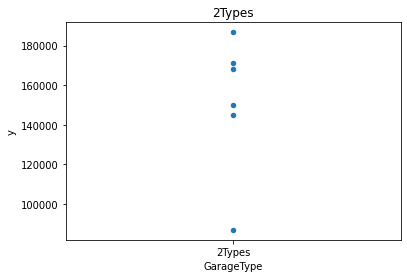

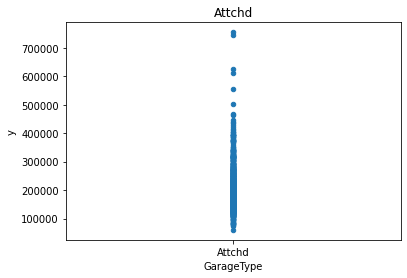

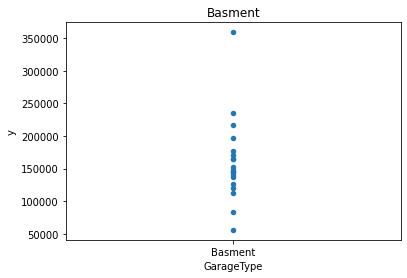

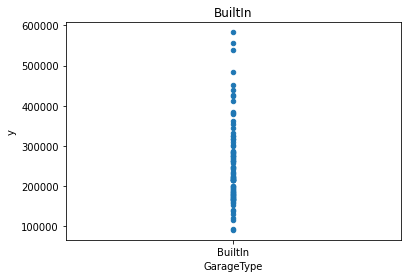

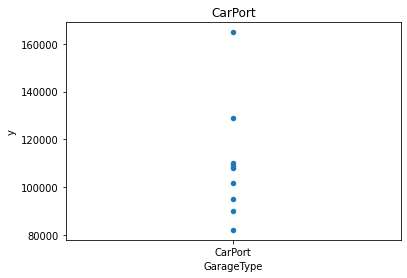

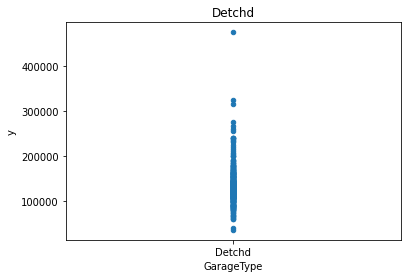

In [56]:
price_by_gt = pd.pivot_table(df, values=y, index=gt, aggfunc=agg_func)

for t in price_by_gt.index:
    df[df[gt] == t].loc[:, [gt, y]].plot(kind='scatter', y=y, x=gt, title=t)

In [57]:
df[gt] = df_train_org[gt].copy()
df[gf] = df_train_org[gf].copy()

In [58]:
# considering the different charts, a reasonable order of types is:
gt_order = ["NA", "CarPort", "2Types", "Basment", "Detchd", "BuiltIn", "Attchd"]

gf_order = ["Fin", "RFn", "Unf","NA"][::-1]

# let's apply this to our train data
for f, o in zip([gt, gf], [gt_order, gf_order]):
    df[f] = df[f].astype("category").cat.set_categories(o, ordered=True)
    df_test[f] = df_test[f].astype("category").cat.set_categories(o, ordered=True)
        
for f, o in zip([gt, gf], [gt_order, gf_order]):    
    df[f] = df[f].apply(ord_to_num(o).get)
    df_test[f] = df_test[f].apply(ord_to_num(o).get)
# fill NaN values
# print(df[(df[gt].isna()) | (df[gf].isna())].loc[:, g_feat])
df.fillna(dict(zip([gt, gf],[0, 0])), inplace=True)
df_test.fillna(dict(zip([gt, gf],[0, 0])), inplace=True)

for f, o in zip([gt, gf], [gt_order, gf_order]):    
    df[f] = df[f].astype(int)
    df_test[f] = df_test[f].astype(int)



The final evaluation of a garage is estimated as:
$\begin{align} 
\frac{c_1 \frac{type}{7} + c_2 \frac{finish}{4}}{2}
\end{align}$
where $c_i$ are calculated out of correlations with the price

In [59]:

corr = np.array([df.loc[:, [f, y]].corr()[y][f] for f in [gt, gf]])
corr = [c / np.sum(corr) for c in corr]
c1 , c2 = corr
print(corr)
g_eval = "g_eval"
def garage_eval(row):
    row[g_eval] = c1 * row[gt] / 7 + c2 * row[gf] / 4 
    row[g_eval] = row[g_eval] / 2
    return row

df = df.apply(garage_eval, axis=1)
df_test = df_test.apply(garage_eval, axis=1)

[0.4218922617058953, 0.5781077382941048]


In [60]:
print(df.loc[:, [gf, gt, g_eval, y]].corr()['y'])

GarageFinish    0.549247
GarageType      0.400830
g_eval          0.540286
y               1.000000
Name: y, dtype: float64


            GarageArea  GarageCars         y
GarageArea    1.000000    0.882475  0.623431
GarageCars    0.882475    1.000000  0.640409
y             0.623431    0.640409  1.000000


<AxesSubplot:title={'center':'garage area and price'}, xlabel='GarageArea', ylabel='y'>

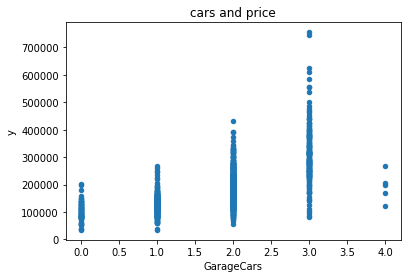

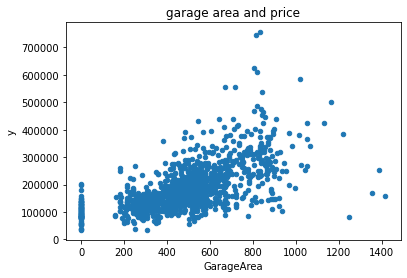

In [61]:
# let's finalize the garage contribution with coupling the garage evaluation with its area
print(df.loc[:, [ga, gc, y]].corr())
# we can easily see that garage's area and garage' cars are highly correlated features, it is superflous to keep both of them.

df.plot(kind='scatter', x=gc, y=y, title='cars and price')
df.plot(kind='scatter', x=ga, y=y, title='garage area and price')


In [62]:
# let's 
area_by_car = pd.pivot_table(df, index=gc, values=ga, aggfunc=agg_func)
print(area_by_car)
price_by_car = pd.pivot_table(df, index=gc, values=y, aggfunc=agg_func)
print("*" * 70)
print(price_by_car)

                count        mean       amax       amin
           GarageArea  GarageArea GarageArea GarageArea
GarageCars                                             
0                  81    0.000000          0          0
1                 369  300.517615        924        160
2                 824  519.797330       1418        320
3                 181  811.574586       1390        478
4                   5  890.400000       1356        480
**********************************************************************
           count           mean    amax    amin
               y              y       y       y
GarageCars                                     
0             81  103317.283951  200500   34900
1            369  128116.688347  266500   35311
2            824  183851.663835  430000   55993
3            181  309636.121547  755000   81000
4              5  192655.800000  265979  123000


In [63]:
# set all 4s in the garage car column to 3
df[gc] = df[gc].apply(lambda x: x if x != 4 else 3)
df_test[gc] = df_test[gc].apply(lambda x: x if x != 4 else 3)

# final estimatation of garage's contribution is the product between g_eval and g_cars
g = "garage"
def set_garage(row):
    row[g] = row[gc] * row[g_eval]
    return row

df = df.apply(set_garage, axis=1)
df_test = df_test.apply(set_garage, axis=1)
print(df.loc[:, [g, y, gc, ga]].corr())
g_feat.append(gy)
df.drop(g_feat, axis=1, inplace=True)
df_test.drop(g_feat, axis=1, inplace=True)
df.drop(g_eval, axis=1, inplace=True)
df_test.drop(g_eval, axis=1, inplace=True)

              garage         y  GarageCars  GarageArea
garage      1.000000  0.740295    0.884956    0.774729
y           0.740295  1.000000    0.646652    0.623431
GarageCars  0.884956  0.646652    1.000000    0.882971
GarageArea  0.774729  0.623431    0.882971    1.000000


#### working with porches

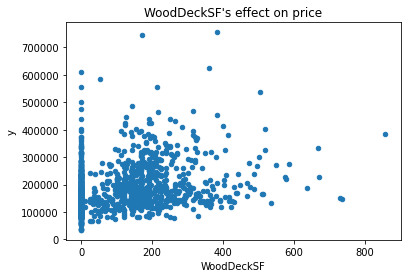

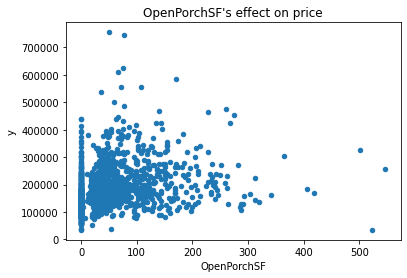

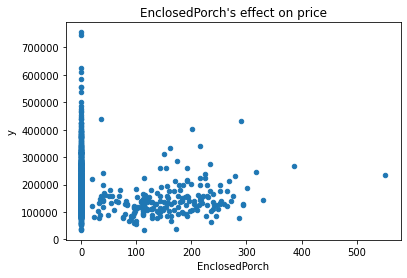

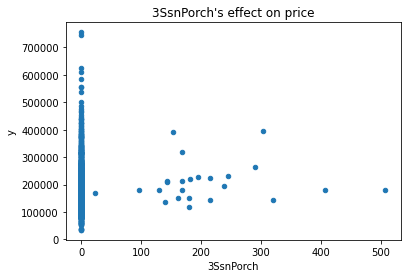

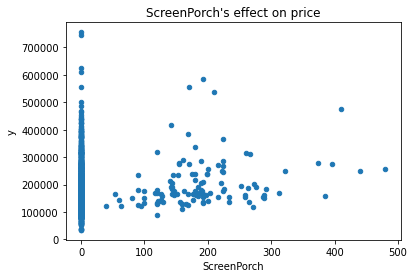

In [64]:
plot_num_feature_price(26, 5)

1    1002
0     458
Name: porch, dtype: int64


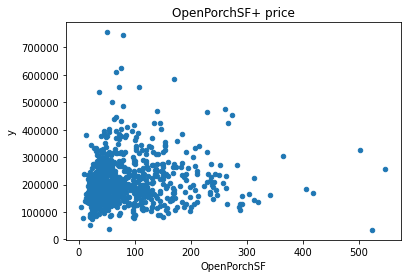

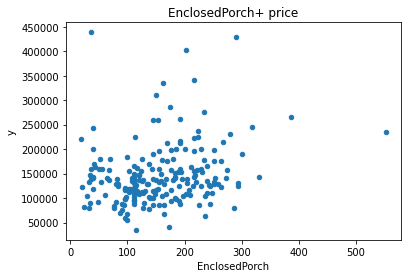

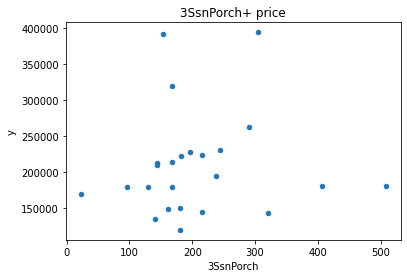

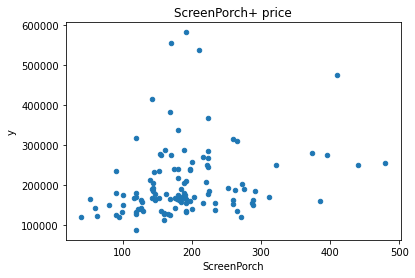

In [65]:
wd = "WoodDeckSF"
p = 'porch'
op = 'OpenPorchSF'
ep = "EnclosedPorch"
s3p = "3SsnPorch"
sp = "ScreenPorch"

p_list = [op, ep, s3p, sp]

df[p] = ((df[op] != 0) + (df[ep] != 0) + (df[s3p] != 0) + (df[sp] != 0)).astype(int)
print(df[p].value_counts())

# a house in the training data has at most one porch
# let's try to estimate the value of each type

for po in p_list:
    df[df[po] != 0].plot(kind='scatter', x=po, y=y, title= po + "+ price")

# the final feature for porchs is the sum of all prochs + the wood deck
df[p] = (df[op] + df[ep] + df[s3p] + df[sp] + df[wd])
df_test[p] = (df[op] + df[ep] + df[s3p] + df[sp] + df[wd])
p_list.append(wd)
df.drop(p_list, axis=1, inplace=True)
df_test.drop(p_list, axis=1, inplace=True)

#### working with other features

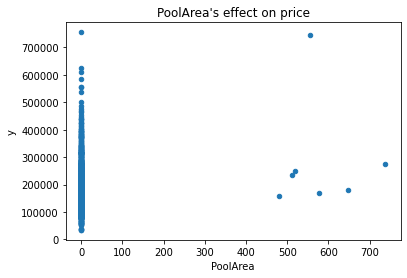

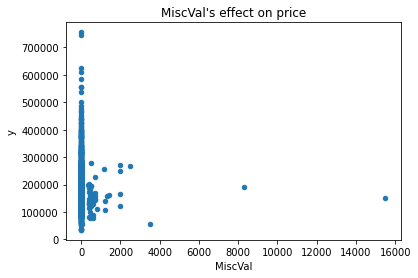

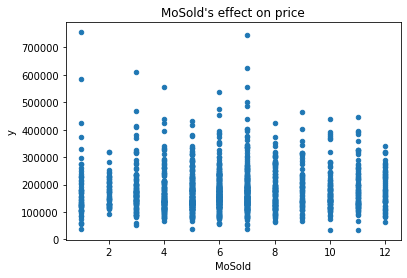

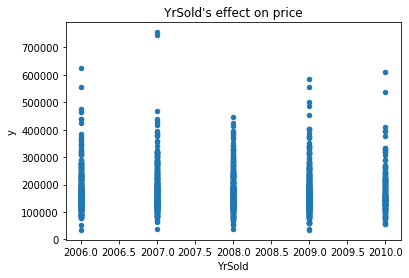

In [66]:
plot_num_feature_price(31, 10)

decisions:
* the pool quality and miscellaneous values columns are to be dropped
* the first and simplest approach is to drop the year as well as the month
* the second is to reconsider the column after considering all other features, read more inflation in the [2006, 2010] period and inject this
knowledge into the model. (For improving the model even further possibly !!)

In [67]:
year = "YearRemodAdd"

def group_by_year(row):
    row['decade'] = 1949 + ((row[year] - 1940) // 10) * 10
    return row

df = df.apply(group_by_year, axis=1)
df_test = df_test.apply(group_by_year, axis=1)

lf = "LotFrontage"
yb = "YearBuilt"
yr = "YearRemodAdd"
pool = "PoolArea"
mis = "MiscVal"
mos = "MoSold"
yrs = "YrSold"

df.drop([lf, yb, yr, pool, mis, mos, yrs], axis=1, inplace=True)
df_test.drop([lf, yb, yr, pool, mis, mos, yrs], axis=1, inplace=True)

#### working with 1st set of categorial features

In [68]:
def plot_cat_feature_price(start, number):
    global df, agg_func
    
    for j in range(start, min(start+number, len(CAT_COLS) - 1)):
        if CAT_COLS[j] in df.columns:
            try:
                df.plot(kind='scatter', x=CAT_COLS[j], y='y', title="{}'s effect on price".format(CAT_COLS[j]))
            except:
                print(pd.pivot_table(df, index=CAT_COLS[j], values=y, aggfunc=agg_func))
        else:
            print(CAT_COLS[j] + " has already been dropped in the previous sections")

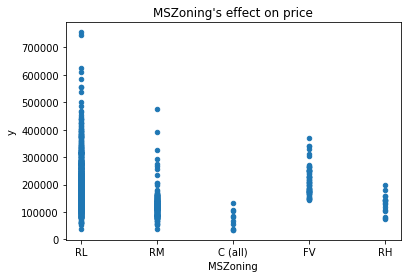

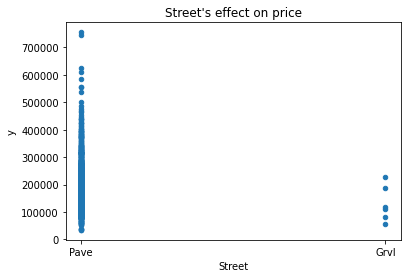

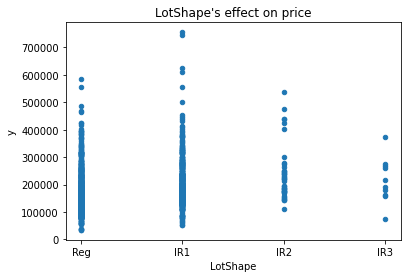

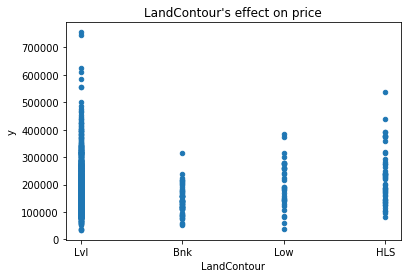

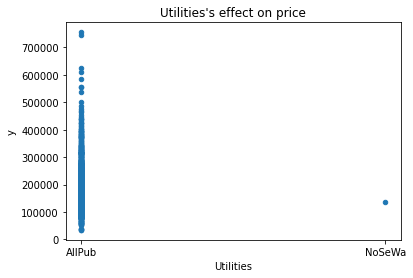

In [69]:
plot_cat_feature_price(0, 5)

In [70]:
# first let's check the Utitilies column in the test dataset
u = "Utilities"
print(len(df_test[df_test[u] != "AllPub"][u]))
# only two outliers in the test set and one in the training set
# the utitilies column is to be dropped
df.drop(u, axis=1, inplace=True)
df_test.drop(u, axis=1, inplace=True)

2


In [71]:
s = "Street"
df.drop(s, axis=1, inplace=True)
df_test.drop(s, axis=1, inplace=True)

In [72]:
zone = "MSZoning"
df[zone] = df_train_org[zone].copy()
price_by_z = pd.pivot_table(df, values=y, index=zone, aggfunc=agg_func)
print(price_by_z)
def set_zone(row):
    z = row[zone]
    if z not in price_by_z.index:
        z = "RL"
    min = price_by_z.loc[z, ('amin', 'y')].squeeze()
    max = price_by_z.loc[z, ('amax', 'y')].squeeze()
    count = price_by_z.loc[z, ('count', 'y')].squeeze()
    row["zone"] = min + (max - min) / count
    return row
df = df.apply(set_zone, axis=1)
df_test = df_test.apply(set_zone, axis=1)
df.drop(zone, axis=1, inplace=True)
df_test.drop(zone, axis=1, inplace=True)

         count           mean    amax    amin
             y              y       y       y
MSZoning                                     
C (all)     10   74528.000000  133900   34900
FV          65  214014.061538  370878  144152
RH          16  131558.375000  200000   76000
RL        1151  191004.994787  755000   39300
RM         218  126316.830275  475000   37900


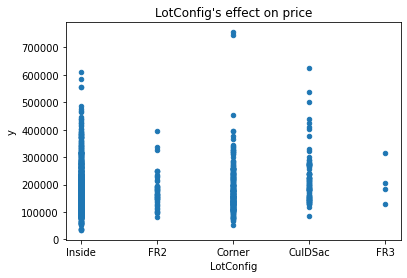

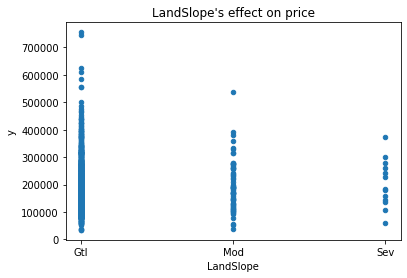

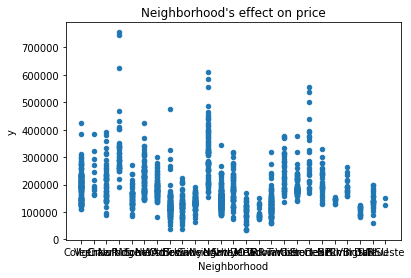

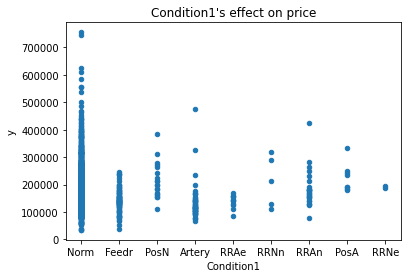

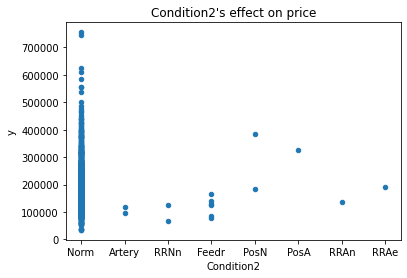

In [73]:
plot_cat_feature_price(5, 5)

In [74]:
# the Neighborhood column requires knowledge of the city itself: it will be temporarily dropped
# the conditions columns can be mainly expressed as an extra noise feature
c1 = "Condition1"
c2 = "Condition2"
n = "Norm"
df['e_noise'] = ((df[c1] != n) + (df[c2] != n)).astype(int)
df_test['e_noise'] = (df_test[c1] != n).astype(int) + (df_test[c2] != n).astype(int)
nei = "Neighborhood"

df.drop([c1, c2, nei], axis=1, inplace=True)
df_test.drop([c1, c2, nei], axis=1, inplace=True)

#### Working with the 2nd set of categorical features

           count           mean    amax    amin
               y              y       y       y
MasVnrType                                     
BrkCmn        15  146318.066667  277000   89471
BrkFace      445  204691.871910  755000   75000
None         864  156221.891204  745000   34900
Stone        128  265583.625000  611657  119000


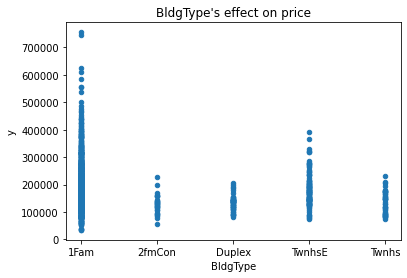

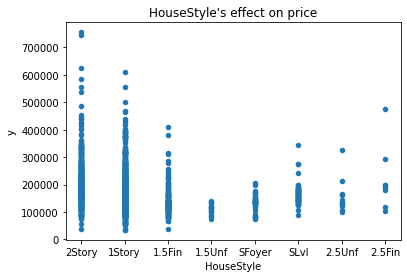

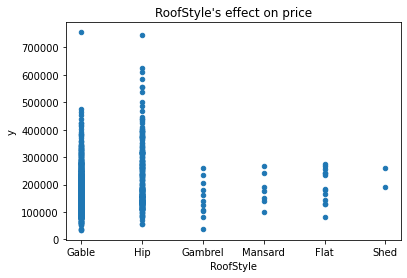

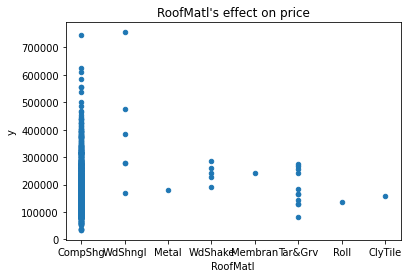

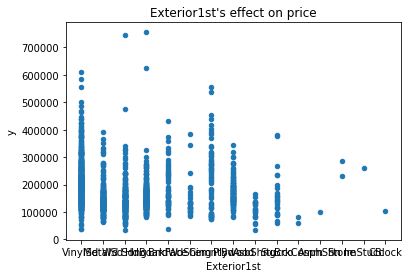

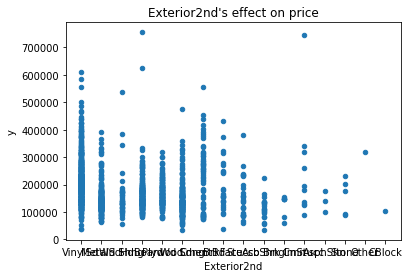

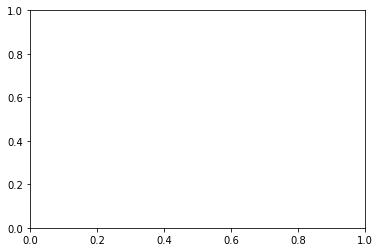

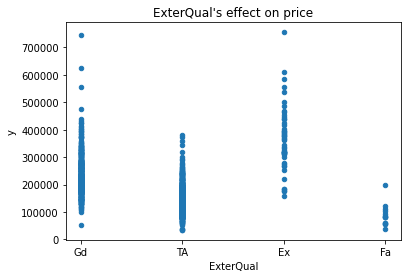

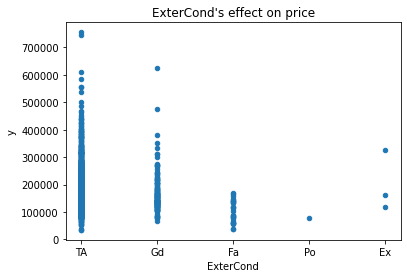

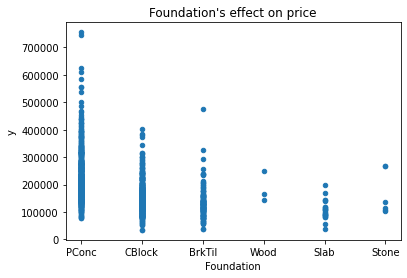

In [75]:
plot_cat_feature_price(10, 10)


In [76]:
# taking into consideration that the first feature represents a a large number of categories 
# the columns "BldgType" and "HouseStyle" can be got rid of.
df.drop(["HouseStyle", "BldgType"], axis=1, inplace=True)
df_test.drop(["HouseStyle", "BldgType"], axis=1, inplace=True)

After conducting slight research on the different available building materials, I decided to group the materials into four groups according to 
reliability and cost.

In [77]:
bad = ["AsbShng","AsphShn","CBlock", "Other"]
good_aff = ["CemntBd", "HdBoard", "ImStucc", "Stucco", "PreCast", "Plywood", "WdShing"]
good_exp = ["Stone", "BrkComm", "BrkFace"]
sidings = ["MetalSd", "VinylSd", "Wd Sdng"]
material = [bad, good_aff, good_exp, sidings]

In [78]:
rf = "RoofStyle"
rm = "RoofMatl"
ex1 = "Exterior1st"
ex2 = "Exterior2nd"
# let's first set the exterior feature
ex = "exterior"

exq = "ExterQual"
exc = "ExterCond"
ex_v = ["Ex","Gd","TA","Fa","Po"][::-1]

df[ex1] = df_train_org[ex1].copy()
df[ex2] = df_train_org[ex2].copy()
df[exq] = df_train_org[exq].copy()
df[exc] = df_train_org[exc].copy()

df_test[ex1] = df_test_org[ex1].copy()
df_test[ex2] = df_test_org[ex2].copy()
df_test[exq] = df_test_org[exq].copy()
df_test[exc] = df_test_org[exc].copy()


In [79]:
for f, o in zip([exq, exc], [ex_v, ex_v]):
    df[f] = df[f].astype("category").cat.set_categories(o, ordered=True)
    df_test[f] = df_test[f].astype("category").cat.set_categories(o, ordered=True)

df_test.fillna({ex1:1, ex2:1}, inplace=True)

for f, o in zip([exq, exc], [ex_v, ex_v]):
    df[f] = df[f].apply(ord_to_num(o).get).astype(int)
    df_test[f] = df_test[f].apply(ord_to_num(o).get).astype(int)



In [80]:
# let's first consider the correlations
corr = np.array([df.loc[:, [f, y]].corr()[y][f] for f in [exq, exc]])
corr = corr / np.sum(corr)
c1, c2 = corr
# np.array([df.loc[:, [f, y]].corr()[y][f]for f in [exq, exc]])

In [81]:

ex_eval = 'ex_eval'
def set_exterior(row):
    global c1, c2
    row[ex_eval] = c1 * row[exq] + c2 * row[exc]
    row[ex] = 0
    mat1 = row[ex1]
    mat2 = row[ex2]
    for i in range(len(material)):
        if mat1 in material[i]:
            row[ex] += i 
        if mat2 in material[i]:
            row[ex] += i
    row[ex] = row[ex] * row[ex_eval]
    return row 

df = df.apply(set_exterior, axis=1)
df_test = df_test.apply(set_exterior, axis=1)

In [82]:
print(df.loc[:, [ex, ex1, ex2, ex_eval, exq, exc, y]].corr()['y'])
# we can experiment with both:, ex_eval and ex, both are not too bad of features
# let's drop features now:
df.drop([ex1, ex2, exq, exc], axis=1, inplace=True)
df_test.drop([ex1, ex2, exq, exc], axis=1, inplace=True)

exterior     0.355174
ex_eval      0.682755
ExterQual    0.682639
ExterCond    0.018899
y            1.000000
Name: y, dtype: float64


#### Working on the 3rd set of categorical features: roof + lot + land

##### Roof

BldgType has already been dropped in the previous sections
HouseStyle has already been dropped in the previous sections
Exterior1st has already been dropped in the previous sections
Exterior2nd has already been dropped in the previous sections
           count           mean    amax    amin
               y              y       y       y
MasVnrType                                     
BrkCmn        15  146318.066667  277000   89471
BrkFace      445  204691.871910  755000   75000
None         864  156221.891204  745000   34900
Stone        128  265583.625000  611657  119000
ExterQual has already been dropped in the previous sections
ExterCond has already been dropped in the previous sections


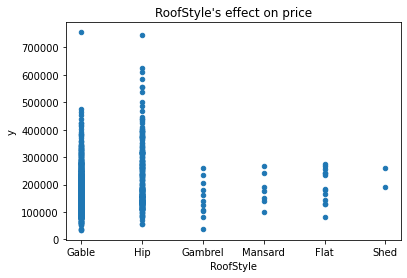

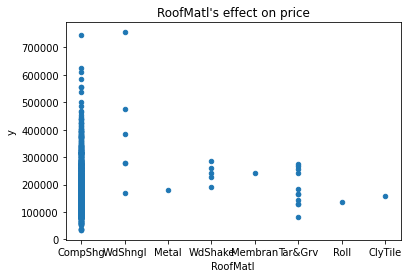

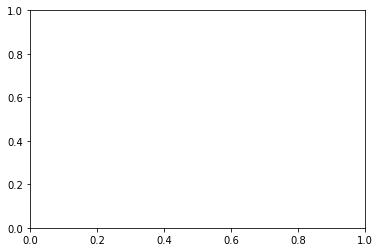

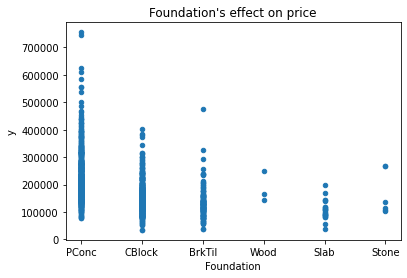

In [83]:
plot_cat_feature_price(10, 10)

In [84]:
# let's pivot the table on roof's type as well as material
rfs = "RoofStyle"
rfm = "RoofMatl"
###
df[rfs] = df_train_org[rfs].copy()
df[rfm] = df_train_org[rfm].copy()
df_test[rfs] = df_test_org[rfs].copy()
df_test[rfm] = df_test_org[rfm].copy()


price_by_rfs = pd.pivot_table(df, index=rfs, values=y, aggfunc=agg_func) 

print(len(df[df[rfm] == "CompShg"]) / len(df))
# the roof's material will be dropped as 98,2 % of the roofs are built with the same material
# let's set the rfs column and check the test dataset first

print(df.loc[df[rfs].isna()]) # no Nan values in the test set

def set_rfs(row):
    rf = row[rfs]
    min = price_by_rfs.loc[rf, ('amin', 'y')].squeeze()
    max = price_by_rfs.loc[rf, ('amax', 'y')].squeeze()
    count = price_by_rfs.loc[rf, ('count', 'y')].squeeze()
    row['roof'] = min + (max - min) / count
    return row

df = df.apply(set_rfs, axis=1)
df_test = df_test.apply(set_rfs, axis=1)
    

0.9821917808219178
Empty DataFrame
Columns: [sub_c, LotShape, LandContour, LotConfig, LandSlope, RoofStyle, RoofMatl, MasVnrType, MasVnrArea, Foundation, Heating, HeatingQC, CentralAir, Electrical, Functional, Fireplaces, FireplaceQu, SaleType, SaleCondition, y, eval, bas, area, baths, area_room, kit, garage, porch, decade, zone, e_noise, ex_eval, exterior]
Index: []

[0 rows x 33 columns]


In [85]:
df.drop([rfs, rfm], axis=1, inplace=True)
df_test.drop([rfs, rfm], axis=1, inplace=True)

##### Lot + Land

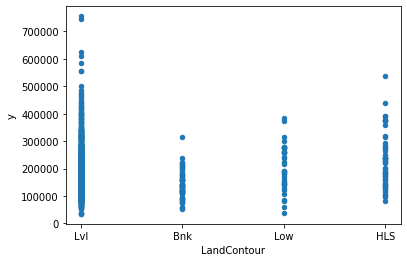

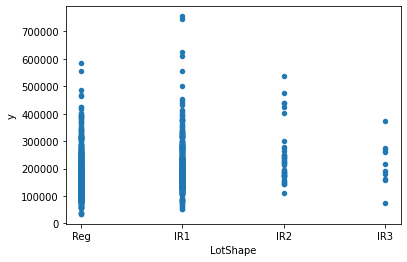

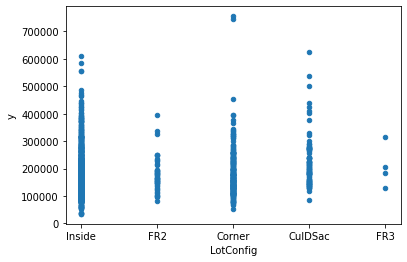

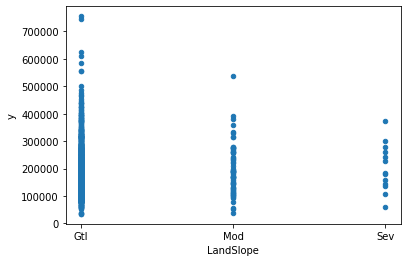

In [86]:
# let's consider the land
lot_land = ["LandContour", "LotShape", "LotConfig", "LandSlope"]
for f in lot_land:
    if f in df.columns: 
        df.plot(kind='scatter', x=f, y=y)
ls = "LotShape"

def set_shape(row):
    row['shape'] = 1 if row[ls] in ["Reg", "IR1"] else 0
    return row

l_c = "LotConfig"
def set_config(row):
    if row[l_c] == "Inside":
        row["config"] = 2
    if row[l_c] == "Corner":
        row['config'] = 1
    else: 
        row['config'] = 0
    return row

l_s = "LandSlope"
def set_slope(row):
    row['slope'] = 1 if row[l_s] == "Gtl" else 0
    return row

l_l_f = [set_config, set_shape, set_slope]
for f in l_l_f:
    df = df.apply(f, axis=1)
    df_test = df_test.apply(f, axis=1)

In [87]:
landc = "LandContour"
df[landc] = df_train_org[landc].copy()
df_test[landc] = df_test_org[landc].copy()


            count           mean    amax   amin
                y              y       y      y
LandContour                                    
Bnk            63  143104.079365  315000  52500
HLS            50  231533.940000  538000  82500
Low            36  203661.111111  385000  39300
Lvl          1311  180183.746758  755000  34900
0
0


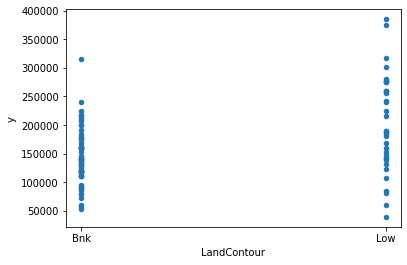

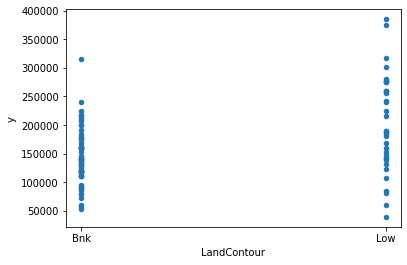

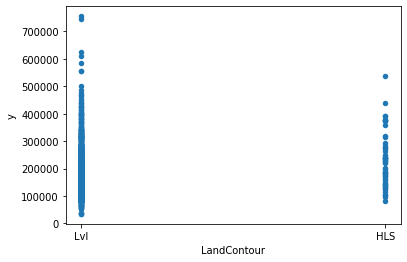

In [88]:
# consider the landcontour 
print(pd.pivot_table(df, values=y, index=landc, aggfunc=agg_func))
df[(df[landc] == 'Bnk') | (df[landc] == 'Low')].plot(kind='scatter', x=landc, y=y)
# we can see that Low is a better option than Bnk

df[(df[landc] == 'Bnk') | (df[landc] == 'Low')].plot(kind='scatter', x=landc, y=y)
df[(df[landc] == 'HLS') | (df[landc] == 'Lvl')].plot(kind='scatter', x=landc, y=y)
# Lvl is indeed a better option than HLS
# then the final order is: 
land_c_o = ["Lvl", "HLS", "Low", "Bnk"][::-1]
# let's fill the Nan values first
print(df[landc].isna().sum())
print(df_test[landc].isna().sum())
# there are no Nan values: thus we can order the values and convert them to int


df[landc] = df[landc].apply(ord_to_num(land_c_o).get).astype(int)

df_test[landc] = df_test[landc].apply(ord_to_num(land_c_o).get).astype(int)

# dropping the original features
df.drop(lot_land, axis=1, inplace=True)
df_test.drop(lot_land, axis=1, inplace=True)


#### Working with Heat and Electricity

In [89]:
h = "Heating"
hq = "HeatingQC"
ca = "CentralAir"
es = "Electrical"
hf = [h, hq, ca, es]
print(pd.pivot_table(df, index=es, values=y, aggfunc=agg_func))
print(df[es].isna().sum())
# he = [h, hq, ca, es]
# for f in he:
#     try:
#         df.plot(kind='scatter', y=y, x=f)
#     except:
#         print(pd.pivot_table(df, index=f, values=y, aggfunc=agg_func))


y_by_elec = pd.pivot_table(df, index='decade', columns=es, aggfunc=['count'], values=y)

print(y_by_elec)

           count           mean    amax   amin
               y              y       y      y
Electrical                                    
FuseA         94  122196.893617  239000  34900
FuseF         27  107675.444444  169500  39300
FuseP          3   97333.333333  137000  73000
Mix            1   67000.000000   67000  67000
SBrkr       1334  186825.113193  755000  37900
1
           count                        
Electrical FuseA FuseF FuseP  Mix  SBrkr
decade                                  
1959        66.0  25.0   2.0  1.0  178.0
1969         5.0   1.0   NaN  NaN  129.0
1979         1.0   NaN   NaN  NaN  172.0
1989         2.0   NaN   NaN  NaN   81.0
1999        14.0   NaN   NaN  NaN  231.0
2009         6.0   1.0   1.0  NaN  537.0
2019         NaN   NaN   NaN  NaN    6.0


In [90]:
# the simplest feature to engineer out of eletrical is turn it into a categorical feature as : isSBrkr
def set_elec(row):
    row['elec'] = 0 if row[es] != 'SBrkr' else 1 
    return row

# the same can be applied to heating type
def set_heat(row):
    row['heat'] = 1 if row[h] != 'GasA' else 2
    points = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}
    row['heat'] = row['heat'] * points[row[hq]]
    return row

df = df.apply(set_elec, axis=1)
df = df.apply(set_heat, axis=1)

df_test = df_test.apply(set_elec, axis=1)
df_test = df_test.apply(set_heat, axis=1)

df["ca"] = df[ca].apply({"N":0, "Y":1}.get)
df_test["ca"] = df_test[ca].apply({"N":0, "Y":1}.get)

In [91]:
df.drop(hf, axis=1, inplace=True)
df_test.drop(hf, axis=1, inplace=True)

In [92]:
df.drop(['Functional',"SaleType"], axis=1, inplace=True)
df_test.drop(['Functional',"SaleType"], axis=1, inplace=True)

The categorical features left so far: 
* MsType
* FirePlaceQuality
* HeatingQuality, central Air
* SaleType

MSZoning has already been dropped in the previous sections
Street has already been dropped in the previous sections
LotShape has already been dropped in the previous sections
LandContour has already been dropped in the previous sections
Utilities has already been dropped in the previous sections
LotConfig has already been dropped in the previous sections
LandSlope has already been dropped in the previous sections
Neighborhood has already been dropped in the previous sections
Condition1 has already been dropped in the previous sections
Condition2 has already been dropped in the previous sections
BldgType has already been dropped in the previous sections
HouseStyle has already been dropped in the previous sections
RoofStyle has already been dropped in the previous sections
RoofMatl has already been dropped in the previous sections
Exterior1st has already been dropped in the previous sections
Exterior2nd has already been dropped in the previous sections
           count           mean    

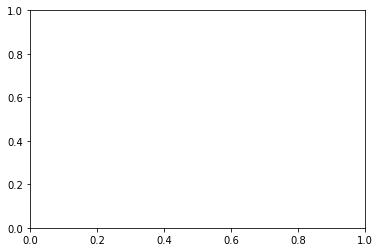

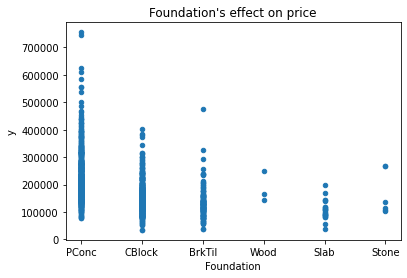

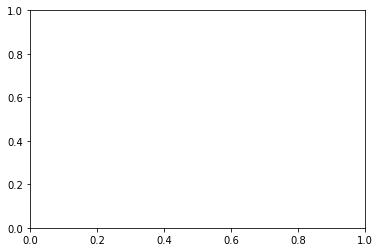

In [93]:
plot_cat_feature_price(0, 55)

MSSubClass has already been dropped in the previous sections
LotFrontage has already been dropped in the previous sections
OverallQual has already been dropped in the previous sections
OverallCond has already been dropped in the previous sections
YearBuilt has already been dropped in the previous sections
YearRemodAdd has already been dropped in the previous sections
BsmtFinSF1 has already been dropped in the previous sections
BsmtFinSF2 has already been dropped in the previous sections
BsmtUnfSF has already been dropped in the previous sections
TotalBsmtSF has already been dropped in the previous sections
1stFlrSF has already been dropped in the previous sections
2ndFlrSF has already been dropped in the previous sections
LowQualFinSF has already been dropped in the previous sections
GrLivArea has already been dropped in the previous sections
BsmtFullBath has already been dropped in the previous sections
BsmtHalfBath has already been dropped in the previous sections
FullBath has alread

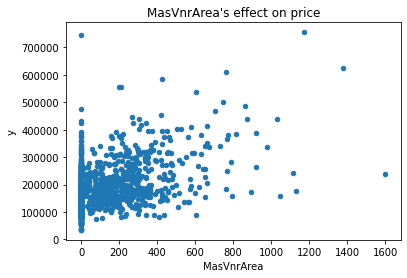

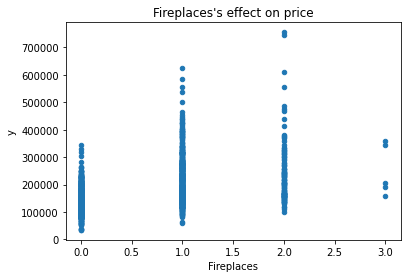

In [94]:
plot_num_feature_price(0, 50)
to_drop = ['MasVnrArea', "Fireplaces", "FireplaceQu", "MasVnrType", "Foundation", 'SaleCondition']
df.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)

In [95]:
# print((df.columns))
# print((df_test.columns))

# additional thoughts on the features:
# baths might not be a very good indicator
# elec , heat, ca can be further merged to a single feature
# ex_eval, exterior can be manipulated even further
# let's check the correlations
print(len(df.corr()['y']) == len(df.columns)) # this means all data is numerical and can be fed to a model
print(df.isna().sum().sum()) # there is no Nan values in the training data set

True
0


In [96]:
from sklearn.preprocessing import StandardScaler
X_train = df.drop(y, axis=1).values
y_train = df[y].values # / 10 ** 3
X_test = df_test.values 


### Linear Models
Very first attempts are to better evaluate the problem's difficulty as well as the quality of the features engineered

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 
print(X_train)
print("#" * 50)
print(X_test)

[[ 1.12009404  0.45499164  0.47511666 ...  0.3073317   0.87030935
   0.26381257]
 [ 0.61644843  1.09250392  1.37710931 ...  0.3073317   0.87030935
   0.26381257]
 [ 1.12009404  0.45499164  0.14722394 ...  0.3073317   0.87030935
   0.26381257]
 ...
 [-0.8944884   1.7300162  -0.36479565 ...  0.3073317   0.87030935
   0.26381257]
 [ 0.61644843 -0.82003292 -0.77050987 ... -3.25381339 -0.11354791
   0.26381257]
 [ 0.61644843 -0.82003292  0.35947638 ...  0.3073317  -0.11354791
   0.26381257]]
##################################################
[[ 0.61644843 -0.82003292  0.03140138 ...  0.3073317  -1.09740517
   0.26381257]
 [ 0.61644843 -0.18252064  1.25252582 ...  0.3073317  -1.09740517
   0.26381257]
 [ 1.12009404 -0.82003292  0.76565583 ...  0.3073317  -0.11354791
   0.26381257]
 ...
 [ 0.61644843 -0.18252064  1.31961904 ...  0.3073317   0.87030935
   0.26381257]
 [-1.90177962 -0.82003292 -0.25806182 ...  0.3073317  -1.09740517
   0.26381257]
 [ 1.12009404  0.45499164  0.53358851 ...  0.30

In [98]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
n_splits = 4
random_state = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


In [99]:
reg = LinearRegression()
# reg.fit(X_train, y_train)

metrics = ['neg_mean_absolute_error', 'r2']
cv_scores = cross_validate(reg, X_train, y_train, cv=kf)
print(cv_scores)
reg.fit(X_train, y_train)

{'fit_time': array([0.0283637 , 0.01139188, 0.01366639, 0.00972772]), 'score_time': array([0.00122905, 0.00111485, 0.00101352, 0.00117898]), 'test_score': array([0.83410461, 0.49819098, 0.86380641, 0.79636127])}


LinearRegression()

In [100]:
def create_sub(y_pred, sub_name):
    global df_test_org
    sub_df = pd.DataFrame({"Id": df_test_org['Id'],"SalePrice": y_pred})
    sub_df.to_csv(sub_name, index=False)

In [101]:
y_pred = reg.predict(X_test) # 10 ** 3
create_sub(y_pred, "first_sub")


In [102]:
def features_coeffs(model, features=None, abv=False):
    if features is None:
        features = df.drop('y', axis=1).columns
    model_coeff = model.coef_
    feat_coeff = dict(zip(features,  model_coeff))
    if abv:
        feat_coeff = dict(zip(features, [abs(coeff) for coeff in model_coeff]))

    feat_coeff = dict(sorted(feat_coeff.items(), key=lambda x:x[1]))
    return feat_coeff



In [103]:
features_coeffs(reg)

{'e_noise': -5173.326928549954,
 'slope': -3390.9835954539044,
 'area_room': -2729.791646834591,
 'elec': -1691.5100607057366,
 'decade': -1648.3467800098138,
 'shape': -962.1530927368527,
 'baths': -75.91073227627147,
 'config': -19.30841806955479,
 'zone': 425.24571507389385,
 'heat': 634.3643856694198,
 'ca': 740.146570802197,
 'exterior': 1517.5531322968438,
 'roof': 2366.2851618483774,
 'porch': 3551.7508093447464,
 'kit': 4381.7663565623025,
 'sub_c': 4514.570044952218,
 'ex_eval': 10561.591057087082,
 'bas': 12548.5112202172,
 'eval': 17093.71742352583,
 'garage': 18741.73643176032,
 'area': 27480.774744955128}

In [104]:
# let's consider regularized Linear regression
# starting with the Lesso model
from sklearn.linear_model import Lasso, LassoLarsCV, LassoCV

l1Reg = LassoLarsCV(cv=kf)
l1Reg.fit(X_train, y_train)
y_pred = l1Reg.predict(X_test)

results_lasso = cross_val_score(l1Reg, X_train, y_train, cv=kf)
create_sub(y_pred, 'lasso.csv')

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 a

In [105]:
print(l1Reg.alpha_)
features_coeffs(l1Reg)

43.95690925307395


{'e_noise': -3278.4172624897988,
 'slope': -1894.0954930142389,
 'baths': 0.0,
 'area_room': 0.0,
 'decade': 0.0,
 'zone': 0.0,
 'config': 0.0,
 'shape': 0.0,
 'elec': 0.0,
 'heat': 0.0,
 'ca': 0.0,
 'exterior': 51.96420254301583,
 'roof': 992.0571551436869,
 'porch': 2481.987343669464,
 'kit': 3289.0761018451244,
 'sub_c': 3660.8489900185805,
 'ex_eval': 11005.531202467168,
 'bas': 11270.292788521136,
 'eval': 16183.145054974788,
 'garage': 18868.403906157433,
 'area': 25761.75447864141}

The differences in coefficients are a source of experimentation
it seems natural to drop "baths", "config", "shape" and "exterior".  
it might be worthwhile imporving each of  "decade", "zone", "elec", "heat" and "ca"  
The confusing part is that slope is assigned a negative value as if it correlates negatively with the price
let's reconsider these features:

In [106]:
# let's consider the original column
print(df_train_org["LandSlope"].value_counts())
print(len(df_train_org[df_train_org["LandSlope"] == 'Gtl']) / len(df))
# the slop feature might indeed be misleading
df.drop('slope', axis=1, inplace=True)
df_test.drop('slope', axis=1, inplace=True)

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
0.9465753424657535


In [107]:
# let's consider a feature related to the year
hy = "YearBuilt"
hyr = "YearRemodAdd"
df[hy] = df_train_org[hy]
df[hyr] = df_train_org[hyr]
df_test[hy] = df_test_org[hy]
df_test[hyr] = df_test_org[hyr]
 
df['renewal'] = (df[yr] == df[hyr]).astype(int)
# let's apply a
h_per_year = df[hy].value_counts().sort_index(ascending=True) 

# x = h_per_year.index
# fig, ax = plt.subplots()
# ax.plot(x, h_per_year.values)
# leg = ax.legend();

# print(pd.pivot_table(df, index='renewal', values='y', ))

In [108]:

def set_built_decade(row):
    row['built_dec'] = (row[hy] - df[hy].min()) // 10
    return row
df = df.apply(set_built_decade, axis=1)

# let's try to work on the age of the house
median_year = df[hy].median()
print(median_year)
df_antique = df[(df[hy] < median_year)]
df_antique_renewed = df[(df[hy] < median_year) & (df[hyr] != df[hy])]

# print(df_antique_renewed.loc[:, [y, hyr, hy]])

# print(df_antique_renewed.loc[:, [y, hyr, hy]].corr())

# # print(df_antique_renewed[y].plot(kind='scatter', x=))
# print(pd.pivot_table(df_antique, index='built_dec', values=y, aggfunc=agg_func))

# let's consider the house's age
last_year = df[hyr].max()

def set_ages(row):
    global last_year
    row['age'] = last_year - row[hy]
    row['n_age'] = last_year - row[hyr]
    return row

df = df.apply(set_ages, axis=1)
df_test = df_test.apply(set_ages, axis=1)
y_age_corr = df.loc[:, [y, 'age', "n_age"]].corr()
c = np.array([y_age_corr[y]['age'], y_age_corr[y]['n_age']])
c = c / np.sum(c)
c1, c2 = c

def set_age_feat(row):
    global c1, c2
    row['age_feat'] = c1 * row['age'] + c2 * row['n_age']
    return row

df = df.apply(set_age_feat, axis=1)
df_test = df_test.apply(set_age_feat, axis=1)

print(df.loc[:, [y, 'age', 'n_age', 'age_feat']].corr()['y']) 

1973.0
y           1.000000
age        -0.522897
n_age      -0.507101
age_feat   -0.575854
Name: y, dtype: float64


1.0    1334
0.0     126
Name: elec, dtype: int64
1.0    1365
0.0      95
Name: ca, dtype: int64
                  y  utilities
y          1.000000   0.426136
utilities  0.426136   1.000000


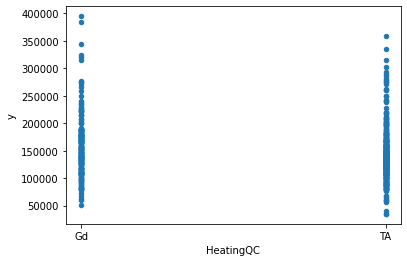

In [109]:
# let's consider the heat elec and ca features
# print(df.loc[:, [y, 'ca', 'elec', 'heat']])
h = "Heating"
hq = "HeatingQC"
df[h] = df_train_org[h]
df[hq] = df_train_org[hq]
df_test[h] = df_test_org[h]
df_test[hq] = df_test_org[hq]

# print(pd.pivot_table(df, index=[h, hq], values=y, aggfunc=agg_func))
# let's slightly consider the houses with GasA heating system and with quality either Good or TA 
df_heat_gas = df[(df[h] == 'GasA') & ((df[hq] == 'Gd') | (df[hq] == 'TA'))]
df_heat_gas.plot(kind='scatter', x=hq, y=y)
# we can see from the plot that neither of those qualities make a difference:thus
# the final classification would be as follows: GasAEx, GasA(Gd, TA), GasA(other), other
def set_heat_final(row):
    value = 0 
    if row[h] != 'GasA':
        value = 0
    elif row[hq] in ['Fa', 'Po']:
        value = 1
    elif row[hq] in ['TA', 'Gd']:
        value = 2
    else:
        value = 3
    row['heat'] = value
    return row

df = df.apply(set_heat_final, axis=1)
df_test = df_test.apply(set_heat_final, axis=1)
print(df['elec'].value_counts())
print(df["ca"].value_counts())
# taking into consideration the imbalanced distribution, it might be worth it to add all three features, heating, elec and ca together

def set_utilities(row):
    row['utilities'] = row['heat'] + row['ca'] + row['elec']
    return row

df = df.apply(set_utilities, axis=1)
df_test= df_test.apply(set_utilities, axis=1)

# df_test = df_test.apply(set_utilities)
print(df.loc[:, [y, 'utilities']].corr()) # this feature seems quite promising

In [110]:
# let's check our features again
print(df.columns)
to_drop_train = ['decade', 'elec', 'heat', 'ca', 'YearBuilt', "YearRemodAdd", 'renewal', 'built_dec', 'age', 'n_age', 'Heating', 'HeatingQC']
df.drop(to_drop_train, axis=1, inplace=True)
print(df.columns)

Index(['sub_c', 'y', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit',
       'garage', 'porch', 'decade', 'zone', 'e_noise', 'ex_eval', 'exterior',
       'roof', 'config', 'shape', 'elec', 'heat', 'ca', 'YearBuilt',
       'YearRemodAdd', 'renewal', 'built_dec', 'age', 'n_age', 'age_feat',
       'Heating', 'HeatingQC', 'utilities'],
      dtype='object')
Index(['sub_c', 'y', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit',
       'garage', 'porch', 'zone', 'e_noise', 'ex_eval', 'exterior', 'roof',
       'config', 'shape', 'age_feat', 'utilities'],
      dtype='object')


In [111]:
to_drop_test = ['decade', 'Heating', 'elec', 'heat', 'ca', 'YearBuilt', 'YearRemodAdd', 'age', 'n_age', 'Heating', 'HeatingQC']
print(df_test.columns) 
df_test.drop(to_drop_test, axis=1, inplace=True)
print(df_test.columns) 

Index(['sub_c', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit', 'garage',
       'porch', 'decade', 'zone', 'e_noise', 'ex_eval', 'exterior', 'roof',
       'config', 'shape', 'elec', 'heat', 'ca', 'YearBuilt', 'YearRemodAdd',
       'age', 'n_age', 'age_feat', 'Heating', 'HeatingQC', 'utilities'],
      dtype='object')
Index(['sub_c', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit', 'garage',
       'porch', 'zone', 'e_noise', 'ex_eval', 'exterior', 'roof', 'config',
       'shape', 'age_feat', 'utilities'],
      dtype='object')


In [112]:
print(df.columns)
print(df_test.columns)

Index(['sub_c', 'y', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit',
       'garage', 'porch', 'zone', 'e_noise', 'ex_eval', 'exterior', 'roof',
       'config', 'shape', 'age_feat', 'utilities'],
      dtype='object')
Index(['sub_c', 'eval', 'bas', 'area', 'baths', 'area_room', 'kit', 'garage',
       'porch', 'zone', 'e_noise', 'ex_eval', 'exterior', 'roof', 'config',
       'shape', 'age_feat', 'utilities'],
      dtype='object')


In [113]:
def X_Y(train_df, test_df, scaler, y='y'):
    X_train = train_df.drop(y, axis=1).values
    X_test = test_df.values
    y_train = df[y].values
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return (X_train, y_train, X_test)

In [114]:
X_train, y_train, X_test = X_Y(df, df_test, scaler)

In [115]:
def lasso_model(X_train, y_train, cv=None):
    global kf
    if cv is None:
        cv = kf
    l1Reg = LassoLarsCV(cv=kf)
    l1Reg.fit(X_train, y_train)
    resLasso = cross_val_score(l1Reg, X_train, y_train, cv=kf)
    return l1Reg, resLasso

In [116]:
l1Reg, resl = lasso_model(X_train, y_train)

# create_sub(y_pred, 'lasso3.csv')

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 a

In [117]:
print(results_lasso)
print(features_coeffs(l1Reg, features=df.drop('y', axis=1).columns))

[0.84079359 0.50847737 0.85300308 0.78995304]
{'e_noise': -3258.1508932982215, 'age_feat': -316.1789883104119, 'baths': 0.0, 'area_room': 0.0, 'zone': 0.0, 'exterior': 0.0, 'config': 0.0, 'shape': 0.0, 'utilities': 0.0, 'roof': 1125.6812988816075, 'porch': 2589.2165014961524, 'kit': 3382.6520203634573, 'sub_c': 3536.5505639991666, 'ex_eval': 10628.394100028449, 'bas': 11471.388516144845, 'eval': 16002.827861381345, 'garage': 18673.45630026559, 'area': 25934.203811440733}


In [118]:
df2 = df.copy()
dft2 = df_test.copy()

In [119]:
# for the l2 regularization, I will keep area_room, zone and utilities as I am quite sure they are relevant
df2.drop(['baths', 'area_room', 'zone', 'exterior', 'config', 'shape', 'utilities'],axis=1, inplace=True)
dft2.drop(['baths', 'area_room', 'zone', 'exterior', 'config', 'shape', 'utilities'],axis=1, inplace=True)

In [120]:
# df.drop([ 'area_room','zone', 'utilities'],axis=1, inplace=True)
# df_test.drop([ 'area_room','zone', 'utilities'],axis=1, inplace=True)

In [121]:
X_train, y_train, X_test = X_Y(df2, dft2, scaler)

In [122]:
from sklearn.linear_model import RidgeCV
def ridge_model(X_train, y_train, a=None, cv=None):
    global kf
    if cv is None: 
        cv = kf
    if a is None:
        a = 10 ** np.linspace(0, 2.5, 200)
    # print(a)
    l2Reg = RidgeCV(alphas=a, scoring='r2', cv=kf)
    l2Reg.fit(X_train, y_train)
    resRidge = cross_val_score(l2Reg ,X_train, y_train, cv=kf)
    return l2Reg, resRidge


In [123]:
l2Reg, resRidge = ridge_model(X_train, y_train)
print(features_coeffs(l2Reg, df2.drop('y', axis=1).columns))
y_pred = l2Reg.predict(X_test) 

{'e_noise': -3854.068949810424, 'age_feat': -3129.5612749134757, 'roof': 2986.668636620713, 'porch': 4703.0628750480155, 'sub_c': 5026.144695720252, 'kit': 5468.79024015432, 'ex_eval': 10324.750776258603, 'bas': 11275.695935700825, 'eval': 14787.273014290115, 'garage': 15468.829656822963, 'area': 22706.06253821708}


In [124]:
print(resRidge)

[0.84182441 0.54639234 0.84974315 0.77715265]


In [125]:
# create_sub(y_pred, 'ridge3.csv')

In [126]:
def save_model_details(model, features, model_name, file_name, ):
     with open(file_name, 'w') as f:
        f.write(model_name + ": \n")
        f.write("hyperparamaters: \n")
      
        f.write(str(model.get_params()))
        f.write("features: \n")
        f.write(str(features)) 
        # print("bro the model passed is not part of the sklearn library") 
        f.close()

In [127]:
# save the lasso model as well as the ridge one
import os
# ridge_file = os.path.join("models", "ridge: 0.18092 .txt")
# lasso_file = os.path.join("models", "lasso: 0.18431 .txt")
# save_model_details(l2Reg, df2.drop(y, axis=1).columns ,"Ridge", ridge_file)
# save_model_details(l1Reg, df2.drop(y, axis=1).columns, "Lasso", lasso_file)
# print(l2Reg.get_params())


## Feature selection
The number of features is quite high which might significantly affect the performance as many of them might be redundant: does not provide any predective utility, or even mislead the model. The feature selection phase is quite important for our current problem

### First approach: convert each column to numerical column and perform a general correlation calculations.
One fast way to have a better understanding of certain features importances is to compute the correlations between the price and every single feature. Considering a minimum trehshold of absolute correlation value, we can drop even more (statistically) uncorrelated features.

In [128]:
df2 = df.copy()
dft2 = df_test.copy()

In [129]:
correlations = df2.corr().loc[["y"],:]

In [130]:
correlations = correlations.transpose().squeeze().sort_values(ascending=False)
correlations_abs = correlations.transpose().squeeze().apply(abs).sort_values(ascending=False)
print(correlations)

y            1.000000
garage       0.740295
area         0.716883
eval         0.704751
ex_eval      0.682755
baths        0.613005
kit          0.608405
area_room    0.546174
bas          0.461053
utilities    0.426136
sub_c        0.414505
porch        0.390993
exterior     0.355174
roof         0.162252
zone         0.073391
config       0.004145
e_noise     -0.112968
shape       -0.129955
age_feat    -0.575854
Name: y, dtype: float64


In [131]:
# based on the correlations here, an optimal set of features woul exclude
# shape, e_noise, config, zone, roof, exterior
df2.drop(["shape", "e_noise", "config", 'zone', "roof", "exterior"], axis=1, inplace=True)
dft2.drop(["shape", "e_noise", "config", 'zone', "roof", "exterior"], axis=1, inplace=True)


In [132]:
# let's experiment with these features
X_train, y_train, X_test = X_Y(df2, dft2,scaler)


In [133]:
l2Reg, l2res = ridge_model(X_train, y_train)

In [134]:
print(l2Reg.alpha_)
print(l2res)

281.6752858487498
[0.83959783 0.49175186 0.83865617 0.76836106]


In [ ]:

l1Reg, l1res = lasso_model(X_train, y_train)
print(l1res)

In [136]:
for l1, l2 in zip(l1res, l2res):
    print("l1: " + str(l1) + ",  l2: " + str(l2))

l1: 0.8457405537022695,  l2: 0.8395978298534299
l1: 0.484820787058454,  l2: 0.49175186048019015
l1: 0.8489462148906028,  l2: 0.8386561667610882
l1: 0.7848810380863263,  l2: 0.7683610620964129


In [137]:
y_pred_l2 = l2Reg.predict(X_test)
create_sub(y_pred_l2, "ridge4.csv")

In [138]:
print(features_coeffs(l1Reg, df2.drop('y', axis=1).columns))

{'age_feat': -722.1819235820557, 'baths': 0.0, 'area_room': 0.0, 'utilities': 0.0, 'porch': 2578.756971296856, 'kit': 3328.430399972601, 'sub_c': 3459.8594881991085, 'ex_eval': 10990.720420926238, 'bas': 11519.189692101996, 'eval': 15912.11710505451, 'garage': 18839.690530159543, 'area': 25618.887095129216}


In [139]:
y_pred_l1 = l1Reg.predict(X_test)
create_sub(y_pred, 'lasso4.csv')

In [140]:
# lasso_file = os.path.join("models", "lasso: 18.092 .txt")
# save_model_details(l1Reg, df2.drop(y, axis=1).columns, "LassoLarCV", lasso_file)

### 2nd Approach: SELECT_K_BEST Functionality

In [171]:
# let's use another feature selection technique
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# get the original dataframes
df2 = df.copy().drop("y", axis=1)
yk = df['y']
dft2 = df_test.copy()

selector = SelectKBest(f_regression, k=12)
X_k = selector.fit_transform(df2, yk) # dfk is currently a np.array with only values
filter = selector.get_support()
Xtk = dft2.loc[: , filter].values
# print(X_k.shape)
# print(yk.shape)
# print(Xtk.shape)
l2regk, l2res= ridge_model(X_k, yk)

# print(X_k)
# print(X_train)
features = df2.loc[:, filter].columns

In [142]:
## save the dataframes to actual csv files
df2.loc[:, filter].to_csv("train_k.csv", index=False)
dft2.loc[:, filter].to_csv("test_k.csv", index=False)


In [143]:
print(l2res)
l2reg_k_sub = os.path.join("subs", "l2regk.csv")
create_sub(l2regk.predict(Xtk), l2reg_k_sub)

[0.84712939 0.48339475 0.85372916 0.79105238]


In [ ]:
l1regk, l1res = lasso_model(X_k, yk)
print(l1res)
l1reg_k_sub = os.path.join("subs", "l1regk.csv")
create_sub(l1regk.predict(Xtk), l1reg_k_sub)

In [145]:
# this is the best linear model so far
# lasso_file = os.path.join("models", "LassoCV: 0.17884 .txt")
# features = df_test.loc[:, filter].columns

# save_model_details(l1regk, features, "lasso classifier", lasso_file)

### Support Vector Machine 
It is time to consider more advanced models such as Support Vector machine. 

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
def hypertune_models(model, para_names:list, init_values:list, expo:list=None, sample_per_iter:int=25, max_iter:int=4, t_scalar:int=0.5, t_expo:int=0.0625):
    if (expo is None): # the default is to use  non-exponential ranges for all hyperparameters
        expo = [False for _ in init_values]
    
    best_models = [] # variable to store the intermediate best models
    values = np.array([np.array(v) for v in init_values]) # convert the init_values parameter into a numpy array of numpy arrays
    values = np.array([10 ** v for (v, e) in zip(values, expo) if e]) # convert the values to exponential range if the corresponding boolean flag is set to True

    params = dict(zip(para_names, values)) # create the dictionary to be used for the

    b_model = GridSearchCV(model, param_grid=params, n_jobs=-1) # find the best combination of hyperparameters

    best_models.append(b_model)

    iters = 1 
    threshold_cond = True
    
    def check_range(v, e):
        if v.dtype == 'object':
            return True
        elif e:
            return (10 ** v[-1] - 10 ** v[0]) >= np.exp(t_expo)
        else:
            return (v[-1] - v[0]) >= t_scalar

    def new_range(v, best_value, e):
        if v.dtype == 'object':
            return v
        if e :
            range = (10 ** v[-1] - 10 ** v[0]) / 2
            return 10 ** np.linspace(best_value - range / 2, best_value + range / 2, sample_per_iter + 1)
        else:
            range = (v[-1] - v[0]) / 2
            return np.linspace(best_value - range / 2, best_value + range / 2, sample_per_iter + 1)


    while (iters < max_iter and threshold_cond):
        # keep tuning as long as at least one parameter's range is still above the treshhold
        threshold_cond = any([check_range(v, e)  for (v, e) in zip(values, expo)]) 

        b_para = b_model.estimator.get_params()
        best_values = np.array([k for (k, v) in b_para.items() if k in para_names]) 
        values = np.array([new_range(v, best_value, e) for (v, best_value, e) in zip(values, best_values, expo)])
        params = dict(zip(para_names, values))
        b_model = GridSearchCV(model, para_grid=params)
        iters += 1
        best_models.append(b_model)
    
    return best_models
            



In [148]:
print(sklearn.metrics.get_scorer_names())


['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [ ]:
from sklearn.svm import SVR
svr = SVR()
scoring = "neg_root_mean_squared_error"

params = {"kernel": ["rbf"], "C":10 ** np.linspace(0, 2, 26), "epsilon": 10 ** np.linspace(-3, 0, 26)}
svr_gs = GridSearchCV(SVR(epsilon = 0.01), params, cv = kf, scoring=scoring)


svr = GridSearchCV(svr, params)
print(cross_val_score(svr, X_k, yk, cv=kf))

In [ ]:
svr.fit(X_k, yk)
svr_predict = svr.predict(Xtk)
svr_sub = os.path.join("subs", "svr1.csv")
create_sub(svr_predict, svr_sub)

### Tree-Based Models
It is time to explore the famous tree-based models:
* DecisionTreeRegressor
* RandomForestRegressor


#### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor


random_state = 3
dreg = DecisionTreeRegressor(max_depth=3, random_state=random_state)
dreg.fit(X_k, yk)

In [180]:
def tree_struct(dt, features_names=None):

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i] if features_names is None else features_names[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )

In [ ]:
tree_struct(dreg, features_names=features)

In [182]:
f_imp = dreg.feature_importances_
print(dict(zip(features, f_imp)))

{'sub_c': 0.0, 'eval': 0.14836304838314107, 'bas': 0.0, 'area': 0.05071984875101684, 'baths': 0.0, 'area_room': 0.03707115644970996, 'kit': 0.0, 'garage': 0.7638459464161321, 'porch': 0.0, 'ex_eval': 0.0, 'age_feat': 0.0, 'utilities': 0.0}


In [ ]:
# it might be worth experimenting with depth = 4
dReg4 = DecisionTreeRegressor(max_depth=4, random_state=random_state)
dReg4.fit(X_k, yk)
tree_struct(dReg4, features_names=features)
f_imp = dReg4.feature_importances_
print(dict(zip(features, f_imp)))

In [ ]:
tree_params = {"max_depth": [3,4,5,6], "min_samples_leaf": range(5, 11), "max_features":["log2", "sqrt"]}

dtr = DecisionTreeRegressor(random_state=random_state)
best_dReg = GridSearchCV(dtr,  param_grid=tree_params, cv=kf, scoring=scoring, refit=True, n_jobs=-1)
best_dReg.fit(X_k, yk)
best_dReg = best_dReg.best_estimator_


In [ ]:
print(cross_val_score(best_dReg, X_k, yk, cv=kf, scoring=scoring))
tree_struct(best_dReg, features)
f_imp = dReg4.feature_importances_
print(dict(zip(features, f_imp)))

#### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as gbr

# the max depth will be reduced to 4
# the rest of the parameters will be set to the same values in bestDReg.

gradb = gbr(max_depth=4, min_samples_leaf=9, random_state=random_state)

lr = [0.0001, 0.001, 0.01, 0.2, 0.3]
n_est = 100  * np.array(range(1, 6))
gradbest = GridSearchCV(gradb, {"learning_rate": lr, "n_estimators": n_est}, cv=kf, scoring=scoring)

gradbest.fit(X_k, yk)

means = gradbest.cv_results_['mean_test_score']
stds = gradbest.cv_results_['std_test_score']
params = gradbest.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
lr_n_est = [i * j for i in lr for j in n_est]


# plot
plt.errorbar(lr_n_est, means, yerr=stds)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('loss')


In [196]:
y_p_dr = best_dReg.predict(Xtk)
create_sub(y_p_dr, "dtr.csv")

#### Random Forests

In [ ]:
# let's try to set a randomforest model for us
from sklearn.ensemble import RandomForestRegressor as rfr
max_d = [3, 4, 5]
max_features = ["sqrt", "log2"]
n_estimators = np.linspace(100, 500, 26).astype(int)

rf = rfr(min_samples_leaf=9, random_state=random_state, n_jobs=-1)
rf_params = {"max_depth":max_d, "n_estimators": n_estimators, "max_features": max_features}
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring=scoring)
rf_grid.fit(X_k, yk)

In [ ]:
df_cat = df2[NUM_COLS]
df_cat_some_null = df_cat.isna().any()
print(df_cat_some_null[df_cat_some_null == True])

Let's consider the 3 features found above:
* LotFrontage: the area of the street leading to the property
* MasVnrArea : Masonry veneer area in square feet
* GarageYrBlt: Year garage was built


##### Imputing LotFrontage

In [ ]:
# a reasonale assumption is correlating the LotFrontage to the zone classification as well as the the street type
lf = "LotFrontage"
msz = "MSZoning"
s = "Street"
lot_frontage_cols = [lf, msz, s]
df_lot_frontage = df2.loc[:, lot_frontage_cols]
lot_frontage_by_zone_street = pd.pivot_table(df_lot_frontage, index=[msz, s], values= lf, aggfunc=['count', 'mean'])

print(lot_frontage_by_zone_street)


In [ ]:
def imput_lot_frontage(row):
    if(np.isnan(row[lf])):
        row[lf] = float(lot_frontage_by_zone_street.loc[(row[msz], row[s]), 'mean'])
    return row

df2 = df2.apply(lambda row: imput_lot_frontage(row), axis=1)
print(df2[lf])

##### Imputing the MasVnrArea feature

In [ ]:
# consider the MasVnrArea feature
mnva = "MasVnrArea"
mnv = "MasVnrType"
print(df2[mnv].value_counts())


In [ ]:
df2[mnva] = df2[mnva].fillna(0)
df2[mnv] = df2[mnv].fillna("None")

##### Imputing the GarageBuiltYear

In [ ]:
# consider the garage building's year
grg = "GarageType"
grg_year = "GarageYrBlt"
no_garage = df2[df2[grg].isna()].index
no_garage_year = df2[df2[grg_year].isna()].index
# print(no_garage == no_garage_year)
df2[grg_year] = df2[grg_year].fillna(0)

#### Applying the Peason's correlation test

In [ ]:
# this is the first test: better understanding correlations between features and sales price.
# let's consider more in-depth features selections processes
# we will use both Pearson’s correlation and Spearman’s rank coefficients for numerical features

num_correlations = [np.corrcoef(df2[col].values, df2["y"].values)[0][1] for col in NUM_COLS]
num_correlations = dict(zip(NUM_COLS, num_correlations))

num_corr_series = pd.Series(num_correlations).sort_values(ascending=False)

In [ ]:
print(num_corr_series)

#### Applying the Spearman's correlation test

In [ ]:
# let's repeat the same process but with Spearman's correlation rank
from scipy.stats import spearmanr

num_corr_2 = [spearmanr(df2[col].values, df2["y"].values)[0] for col in NUM_COLS]
num_corr_2_p = [spearmanr(df2[col].values, df2["y"].values)[1] for col in NUM_COLS]
num_corr_2_series = pd.Series(dict(zip(NUM_COLS, num_corr_2)))
num_corr_2_p_series = pd.Series(dict(zip(NUM_COLS, num_corr_2_p)))
# print(num_corr_2_series)
# print(num_corr_2_p_series)

In [ ]:
num_corr_df = pd.DataFrame([num_corr_2, num_corr_2_p], index=['corr', 'p']).transpose()
# consider the columns that are statistically correlated with the sale price
num_corr_df = num_corr_df[(abs(num_corr_df['corr']) >= .1) & (num_corr_df['p'] < 0.05)] 

NUM_COLS = [NUM_COLS[i] for i in range(len(NUM_COLS)) if i in list(num_corr_df.index)]
NUM_COLS_LEFT = [NUM_COLS[i] for i in range(len(NUM_COLS)) if i not in list(num_corr_df.index)]

#### Applying the Kendalltau rank coefficient on categorical features

In [ ]:
from scipy.stats import kendalltau

cat_corr_2 = [kendalltau(df2[col].values, df2["y"].values)[0] for col in CAT_COLS]
cat_corr_2_p = [kendalltau(df2[col].values, df2["y"].values)[1] for col in CAT_COLS]
cat_corr_2_series = pd.Series(dict(zip(CAT_COLS, cat_corr_2)))
cat_corr_2_p_series = pd.Series(dict(zip(CAT_COLS, cat_corr_2_p)))
# print(num_corr_2_series)
# print(num_corr_2_p_series)

In [ ]:
cat_corr_df = pd.DataFrame([cat_corr_2, num_corr_2_p], index=['corr', 'p']).transpose()
# consider the columns that are statistically correlated with the sale price
cat_corr_df = cat_corr_df[(abs(cat_corr_df['corr']) >= .1) & (cat_corr_df['p'] < 0.05)] 

CAT_COLS = [CAT_COLS[i] for i in range(len(CAT_COLS)) if i in list(cat_corr_df.index)]
CAT_COLS_LEFT = [CAT_COLS[i] for i in range(len(CAT_COLS)) if i not in list(cat_corr_df.index)]

#### Consider poorly correlated features

In [ ]:
print(NUM_COLS_LEFT)
print(CAT_COLS_LEFT)

After consuling the file description, it can be seen that certain features impose certain order on the different categories: 
* Utilities: the number of services available in the neighborhood
* LandSlope: the slope of the land
* ExterQual: the quality of exterior material 
* ExterCond: quality of the exterior material
* BsmtQual: basement quality 
* BsmtCond: basement condition
* BsmtExposure: exposure
* BsmtFinType1: the quality of the basement's finished area
* BsmtFinType2: the quality of the basement's additional areas
* HeatingQC: Heating quality and condition
* Electrical: Electrical system
* KitchenQual: Kitchen quality
* Functional: Home functionality
* FireplaceQu: Fireplace quality
* GarageFinish: Interior finish of the garage
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* PoolQC: Pool quality: dropped because of nan-value ratio
* Fence: Fence quality: dropped because of nan-value ratio

In [ ]:
ORD_COL = ["Utilities", "LandSlope", "ExterQual", "ExterCond", "BsmtQual",
"BsmtCond","BsmtExposure","BsmtFinType1", "BsmtFinType2","HeatingQC","Electrical","KitchenQual",
"Functional","FireplaceQu","GarageFinish","GarageQual", "GarageCond","PavedDrive"]